##  1. Contexte du projet

La **consommation énergétique** des bâtiments est aujourd’hui un enjeu mondial majeur.

* En Europe par exemple, le secteur du bâtiment représente environ **40% de la consommation d’énergie totale** et **36% des émissions de CO₂**.
* Réduire la consommation énergétique et améliorer l’efficacité thermique des bâtiments est donc une priorité pour des raisons **économiques** (réduction des coûts) et **environnementales** (transition énergétique, réduction des émissions).

C’est dans ce cadre que l’**UCI Machine Learning Repository** propose le **Energy Efficiency Dataset**, un jeu de données construit par Tsanas & Xifara (Université d’Édimbourg, 2012).
Il contient des **simulations thermiques de bâtiments résidentiels** en fonction de leurs caractéristiques structurelles et d’orientation.


##  2. Description du jeu de données

Le dataset comporte **768 échantillons** (observations), correspondant à différents types de bâtiments simulés.

 **Variables d’entrée (features, X) – 8 caractéristiques du bâtiment :**

1. **Relative Compactness** : compacité du bâtiment (rapport entre volume et surface externe).

   * Plus un bâtiment est compact, moins il a de pertes thermiques.
2. **Surface Area** : surface totale des murs extérieurs (m²).
3. **Wall Area** : surface des murs (m²).
4. **Roof Area** : surface du toit (m²).
5. **Overall Height** : hauteur du bâtiment (m).
6. **Orientation** : orientation principale du bâtiment (codée en 2, 3, 4, 5 → Nord, Est, Sud, Ouest).
7. **Glazing Area** : proportion de surface vitrée (% de fenêtres).
8. **Glazing Area Distribution** : distribution des surfaces vitrées (codée en 0, 1, 2, 3, 4 → aucune, uniforme, nord, est, sud, ouest).

 **Variables cibles (y) – 2 valeurs de sortie :**

1. **Heating Load (HL)** : charge de chauffage (kWh/m²).
2. **Cooling Load (CL)** : charge de refroidissement (kWh/m²).


## 3. Objectif du dataset

L’objectif principal est de **prédire les charges énergétiques (chauffage et refroidissement)** à partir des caractéristiques structurelles du bâtiment.

# *1. Import des bibliothèques principales*

In [1]:
!pip install xgboost

In [2]:
import pandas as pd      # Manipulation de données (dataframes)
import numpy as np       # Calculs numériques
import matplotlib.pyplot as plt  # Visualisations basiques
import seaborn as sns    # Visualisations avancées


from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate
from sklearn.exceptions import ConvergenceWarning

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action="ignore", category=ConvergenceWarning)

# *2. Chargement du dataset*

In [3]:
df = pd.read_csv("db/ENB2012_data.csv")
df

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28
...,...,...,...,...,...,...,...,...,...,...
763,0.64,784.0,343.0,220.50,3.5,5,0.4,5,17.88,21.40
764,0.62,808.5,367.5,220.50,3.5,2,0.4,5,16.54,16.88
765,0.62,808.5,367.5,220.50,3.5,3,0.4,5,16.44,17.11
766,0.62,808.5,367.5,220.50,3.5,4,0.4,5,16.48,16.61


In [4]:
#Nouveau mapping pour les colonnes explicatives
new_columns = {
    "X1": "Relative Compactness",
    "X2": "Surface Area",
    "X3": "Wall Area",
    "X4": "Roof Area",
    "X5": "Overall Height",
    "X6": "Orientation",
    "X7": "Glazing Area",
    "X8": "Glazing Area Distribution"
}
# Y1 : Heating Load (HL)** : charge de chauffage (kWh/m²).
# Y2: Cooling Load (CL)** : charge de refroidissement (kWh/m²).
df = df.rename(columns = new_columns)
df.head()

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


# *3. Étape 2 : Exploration des données (EDA – Exploratory Data Analysis)*

### *General information*

In [5]:
def check_df(df): 
    print("######################### Head #########################")
    print(df.head())
    print("######################### Dimensions du dataset #########################")
    print(df.shape)
    print("######################### Types de variables valeurs manquantes #########################")
    print(df.info())
    print("######################### Vérification des valeurs manquantes #########################")
    print(df.isnull().sum())
    print("######################### statistiques descriptives #########################")
    print(df.describe().T)
    

In [6]:
check_df(df)

######################### Head #########################
   Relative Compactness  Surface Area  Wall Area  Roof Area  Overall Height  \
0                  0.98         514.5      294.0     110.25             7.0   
1                  0.98         514.5      294.0     110.25             7.0   
2                  0.98         514.5      294.0     110.25             7.0   
3                  0.98         514.5      294.0     110.25             7.0   
4                  0.90         563.5      318.5     122.50             7.0   

   Orientation  Glazing Area  Glazing Area Distribution     Y1     Y2  
0            2           0.0                          0  15.55  21.33  
1            3           0.0                          0  15.55  21.33  
2            4           0.0                          0  15.55  21.33  
3            5           0.0                          0  15.55  21.33  
4            2           0.0                          0  20.84  28.28  
######################### Dimensions

In [7]:
df.describe()

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Y1,Y2
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000,768.000000,768.000000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250,22.307201,24.587760
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096,10.090196,9.513306
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000,6.010000,10.900000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000,12.992500,15.620000
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000,18.950000,22.080000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000,31.667500,33.132500
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000,43.100000,48.030000


In [8]:
df.describe([0.05,0.1,0.30,0.5,0.75,0.90]).T

,count,mean,std,min,5%,10%,30%,50%,75%,90%,max
Relative Compactness,768.0,0.764167,0.105777,0.62,0.6200,0.640,0.690,0.75,0.8300,0.900,0.98
Surface Area,768.0,671.708333,88.086116,514.50,514.5000,563.500,612.500,673.75,741.1250,784.000,808.50
Wall Area,768.0,318.500000,43.626481,245.00,245.0000,269.500,294.000,318.50,343.0000,367.500,416.50
Roof Area,768.0,176.604167,45.165950,110.25,110.2500,122.500,147.000,183.75,220.5000,220.500,220.50
Overall Height,768.0,5.250000,1.751140,3.50,3.5000,3.500,3.500,5.25,7.0000,7.000,7.00
Orientation,768.0,3.500000,1.118763,2.00,2.0000,2.000,3.000,3.50,4.2500,5.000,5.00
Glazing Area,768.0,0.234375,0.133221,0.00,0.0000,0.100,0.100,0.25,0.4000,0.400,0.40
Glazing Area Distribution,768.0,2.812500,1.550960,0.00,0.0000,1.000,2.000,3.00,4.0000,5.000,5.00
Y1,768.0,22.307201,10.090196,6.01,10.4635,11.217,14.320,18.95,31.6675,36.703,43.10
Y2,768.0,24.587760,9.513306,10.90,13.6175,14.237,16.278,22.08,33.1325,37.422,48.03


**Relative Compactness** : **ecart-type : 0.1057, peu de variabilité** : pas de valeurs aberrantes, relativement concentrée autour de 0.7 et 0.8

**Roof Area** : 2 valeurs typiques : 110.25 et 220.50 donc variable discrète

**Overall Height**: Variable Catégorielle : 3.5 et 7

**Orientation** : Variables Categorielle entières entre 2 et 5

**Glazing Area** : Categorielle 0, 0.1, 0.25, 0.4 

**GA Distribution** : categorielle entières entre 0 et 5

**Y1** : Moyenne 22.30 mais gros écart-type (10) 
Distribution asymétrique: 50 % ds valeurs inf à 19 mais des valeurs montent jusqu'à 43 : présence des batiments énérgivores: potentiels outliers légitimes 

**Analyse des variables**

In [9]:
# 1) Détection automatique
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
non_numeric_cols = df.select_dtypes(exclude=['number']).columns.tolist()

print("Colonnes numériques détectées :", numeric_cols)
print("Autres colonnes :", non_numeric_cols)

Colonnes numériques détectées : ['Relative Compactness', 'Surface Area', 'Wall Area', 'Roof Area', 'Overall Height', 'Orientation', 'Glazing Area', 'Glazing Area Distribution', 'Y1', 'Y2']
Autres colonnes : []


**Détection des colonnes catégorielles codées en numérique**

In [10]:
# tableau récapitulatif avec nombre de modalités et un échantillon de valeurs
summary = pd.DataFrame({
    'dtype': df.dtypes,
    'n_unique': df.nunique(),
    'sample_values': [df[col].unique()[:10] for col in df.columns]
})
summary = summary.sort_values('n_unique')
summary

,dtype,n_unique,sample_values
Overall Height,float64,2,"[7.0, 3.5]"
Roof Area,float64,4,"[110.25, 122.5, 147.0, 220.5]"
Orientation,int64,4,"[2, 3, 4, 5]"
Glazing Area,float64,4,"[0.0, 0.1, 0.25, 0.4]"
Glazing Area Distribution,int64,6,"[0, 1, 2, 3, 4, 5]"
Wall Area,float64,7,"[294.0, 318.5, 343.0, 416.5, 245.0, 269.5, 367.5]"
Relative Compactness,float64,12,"[0.98, 0.9, 0.86, 0.82, 0.79, 0.76, 0.74, 0.71..."
Surface Area,float64,12,"[514.5, 563.5, 588.0, 612.5, 637.0, 661.5, 686..."
Y1,float64,586,"[15.55, 20.84, 21.46, 20.71, 19.68, 19.5, 19.9..."
Y2,float64,636,"[21.33, 28.28, 25.38, 25.16, 29.6, 27.3, 21.97..."


## Classification des variables explicatives

1. **Variables ordinales (valeurs discrètes mais avec un ordre logique)**

   * `Relative Compactness` (12 niveaux ordonnés : 0.98, 0.9, …)
   * `Surface Area` (12 niveaux ordonnés : 514.5, 563.5, …)
   * `Wall Area` (7 niveaux ordonnés : 245.0, 269.5, …)

2. **Variables catégorielles nominales (pas d’ordre, juste des catégories)**

   * `Orientation` (4 niveaux : 2,3,4,5 → cardinal, pas d’ordre naturel).
   * `Glazing Area Distribution` (6 niveaux → nominal).
3. **Variables ordinales avec peu de niveaux**

   * `Roof Area` (4 niveaux croissants : 110.25, 122.5, 147.0, 220.5).
   * `Overall Height` (2 niveaux : 3.5 et 7.0).
   * `Glazing Area` (4 niveaux : 0.0, 0.1, 0.25, 0.4).

## Variables Cibles
**Y1 et Y2 sont réellement les seules variables numériques continues avec n_unique supérieure à 15.**

In [11]:
##**Choix d’un seuil automatique pour considérer une colonne comme « catégorielle »**
# seuil recommandé (à adapter) : <= 10 modalités → candidate catégorielle
#threshold = 10
#candidates = [col for col in df.columns if df[col].nunique() <= threshold and col not in ['Y1','Y2','Wall Area']]
#candidates

## **Analyse des distributions et visualisation des variables**

**Visualiser les variables numériques**

- Histogrammes ou KDE plots → pour voir la distribution (normale, asymétrique, bimodale, etc.).

- Boxplots → pour détecter les outliers.

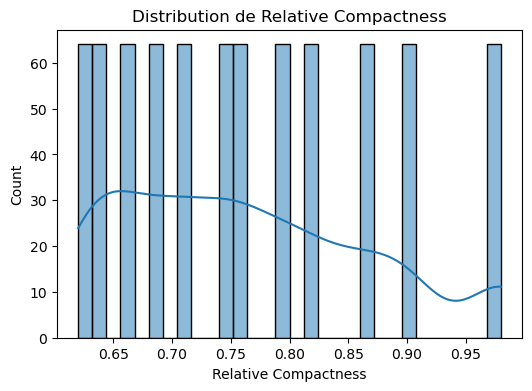

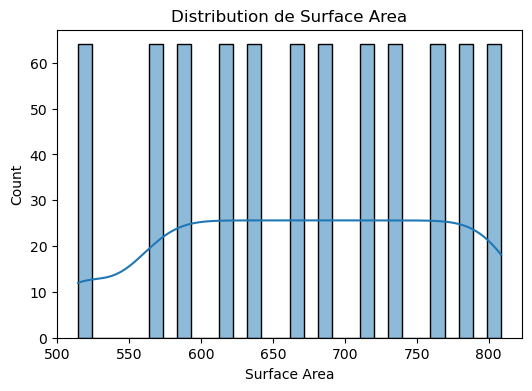

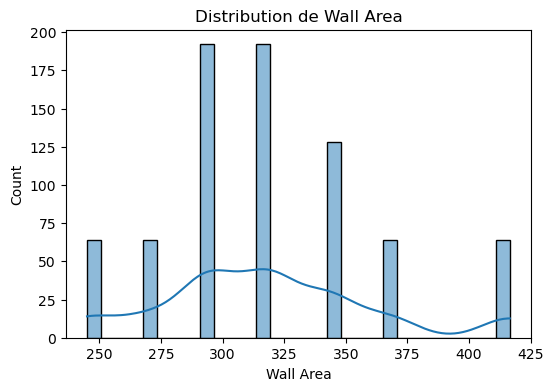

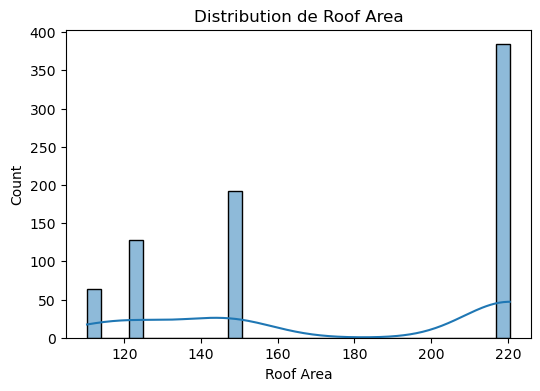

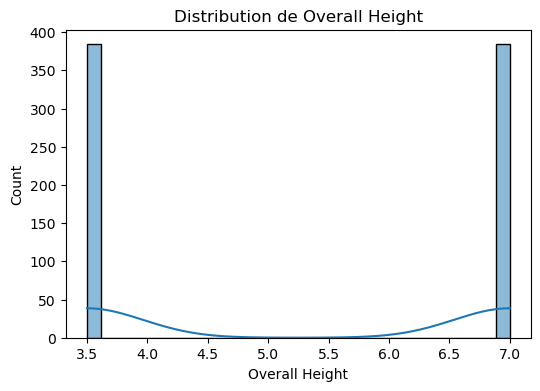

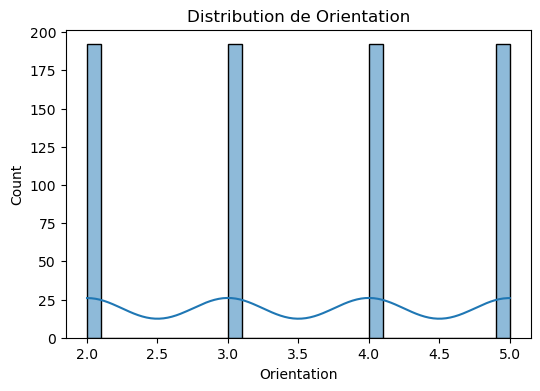

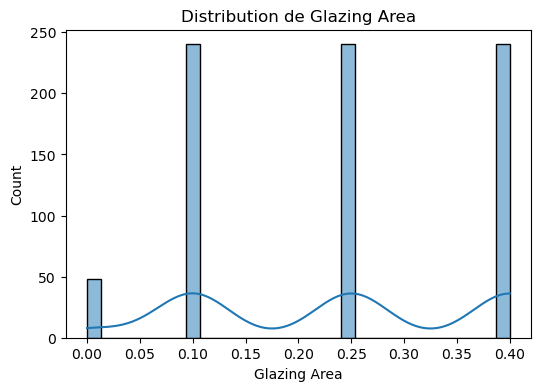

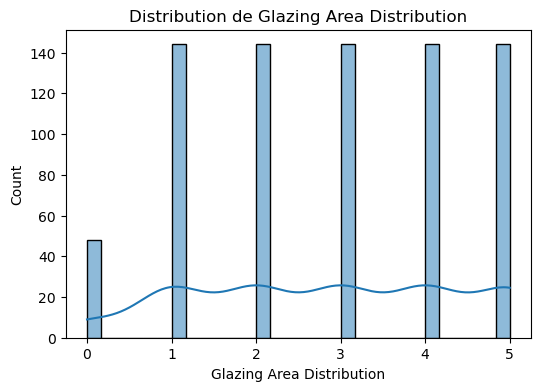

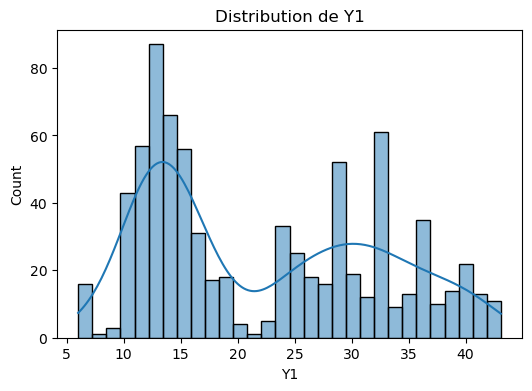

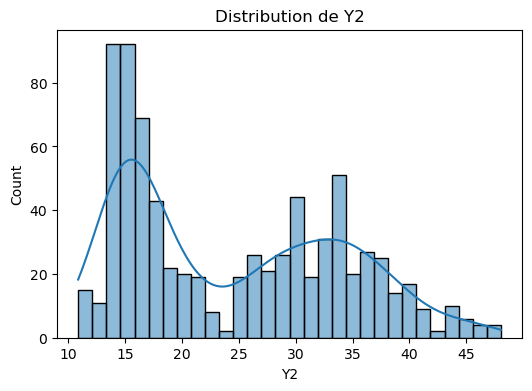

In [12]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution de {col}')
    plt.show()

In [13]:
numeric_cols

Index(['Relative Compactness', 'Surface Area', 'Wall Area', 'Roof Area',
       'Overall Height', 'Orientation', 'Glazing Area',
       'Glazing Area Distribution', 'Y1', 'Y2'],
      dtype='object')

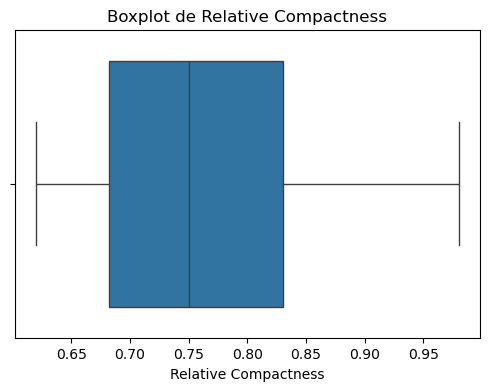

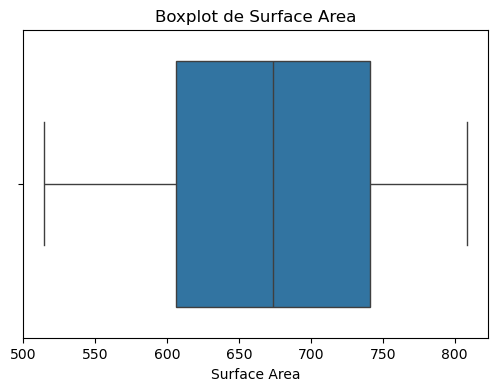

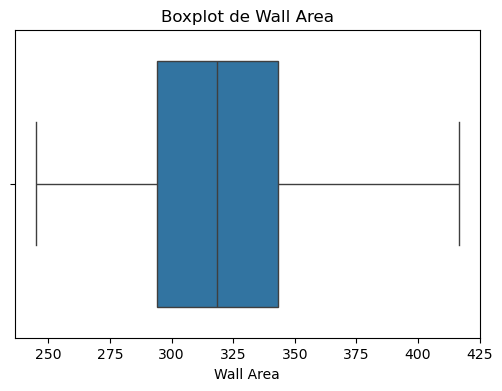

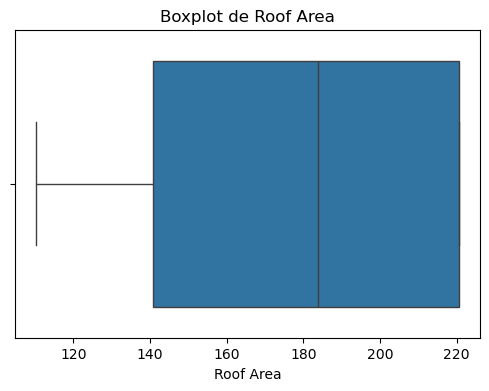

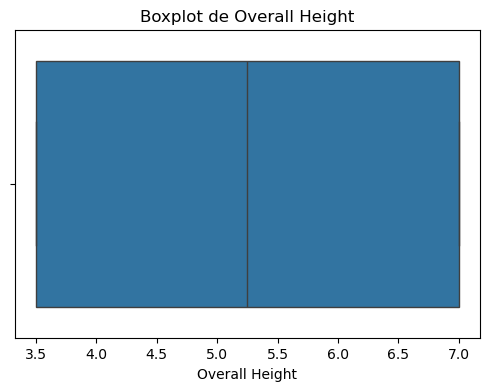

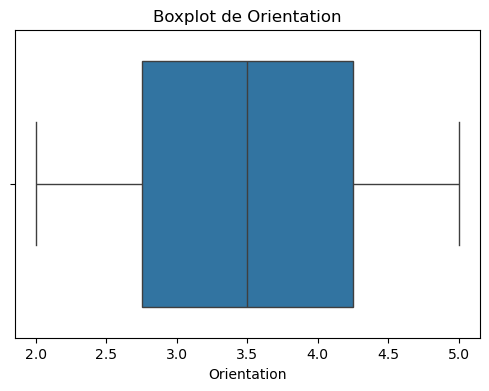

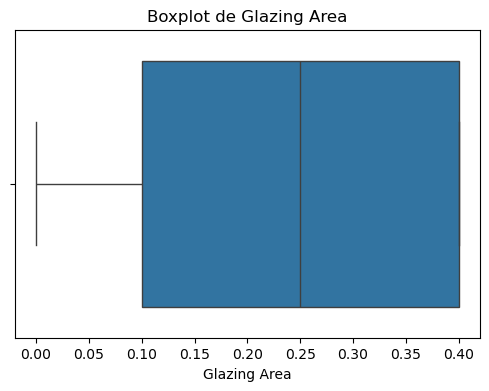

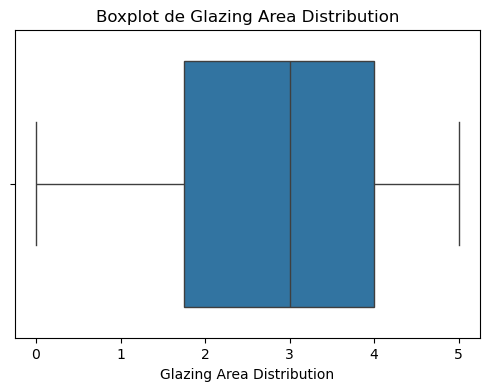

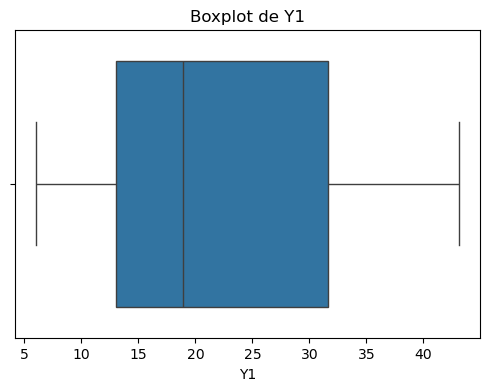

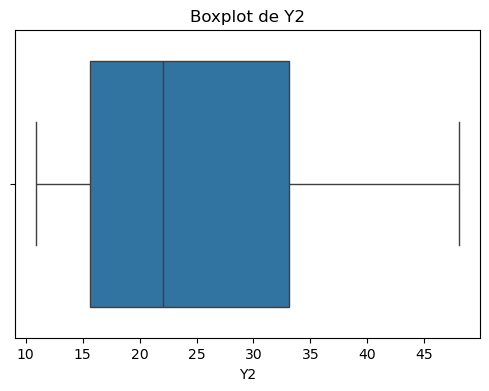

In [14]:
for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot de {col}')
    plt.show()

**Visualiser les variables catégorielles**

- Compter les fréquences (value_counts)

- Diagrammes en barres (countplot)

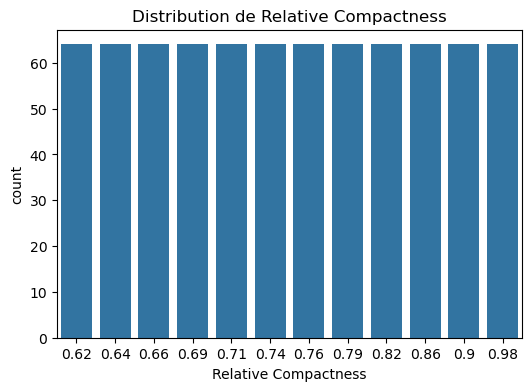

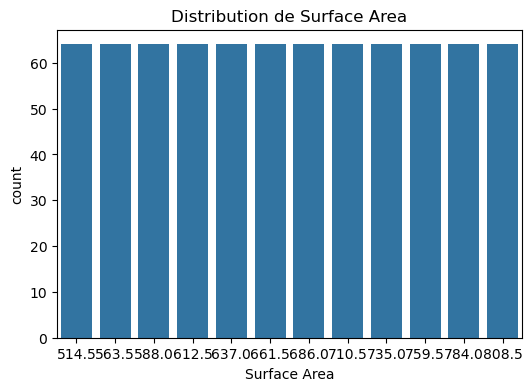

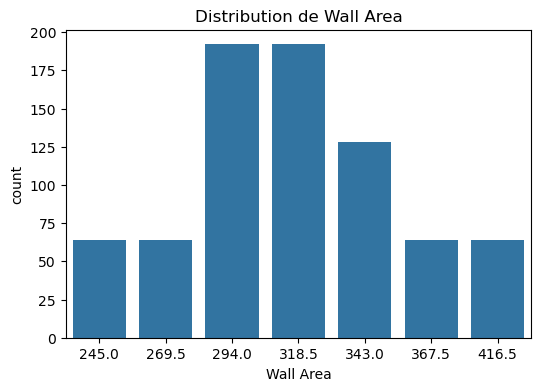

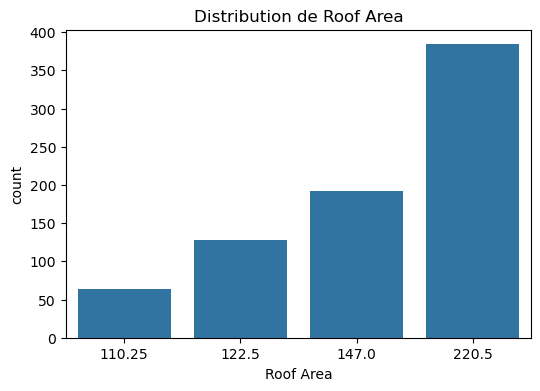

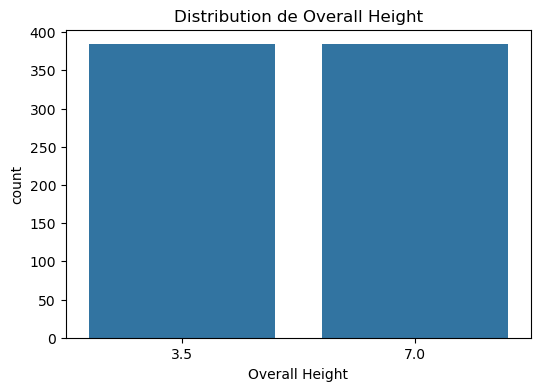

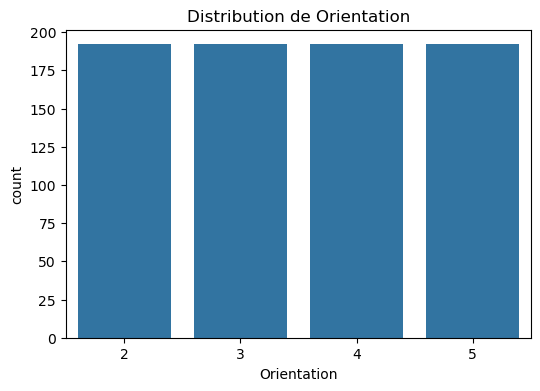

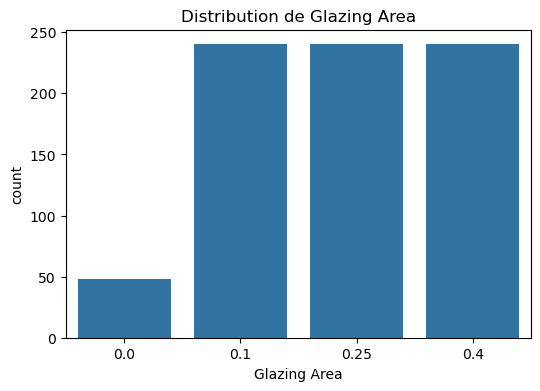

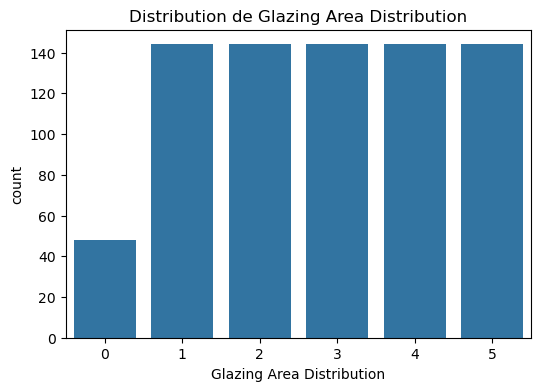

In [15]:
#categorical_cols = df.select_dtypes(include=['category']).columns
categorical_cols= df.drop(columns = ["Y1","Y2"])
for col in categorical_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=df[col])
    plt.title(f'Distribution de {col}')
    plt.show()


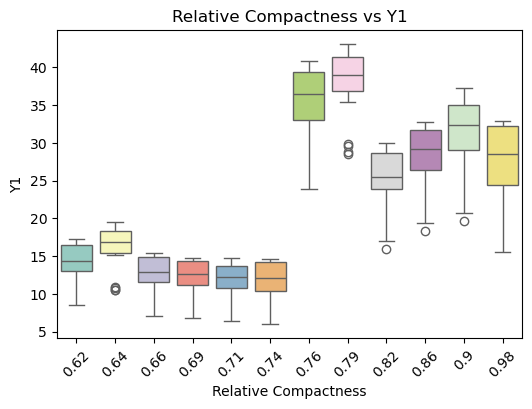

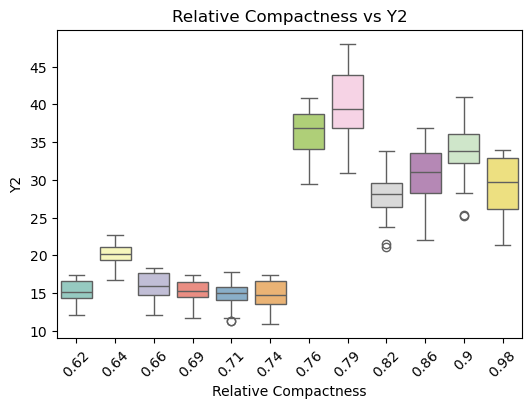

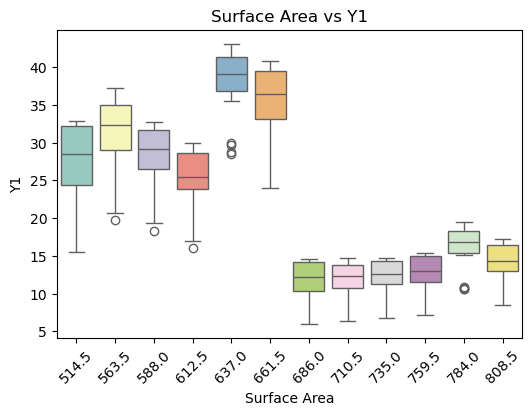

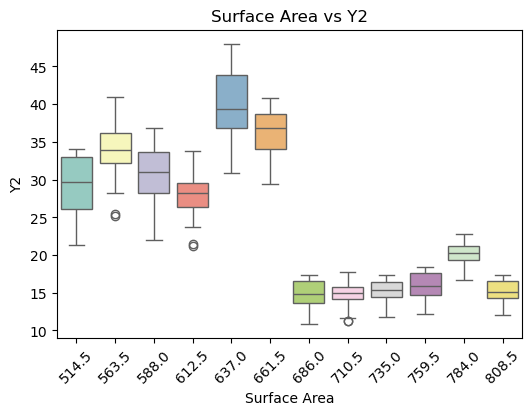

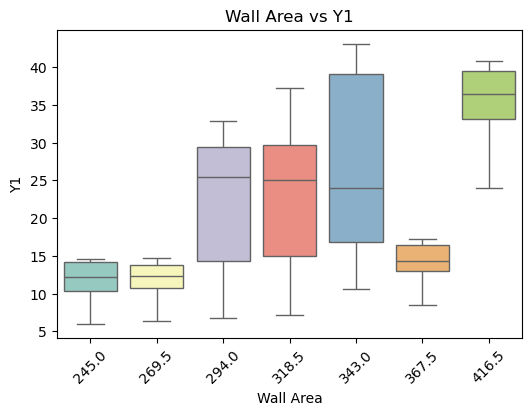

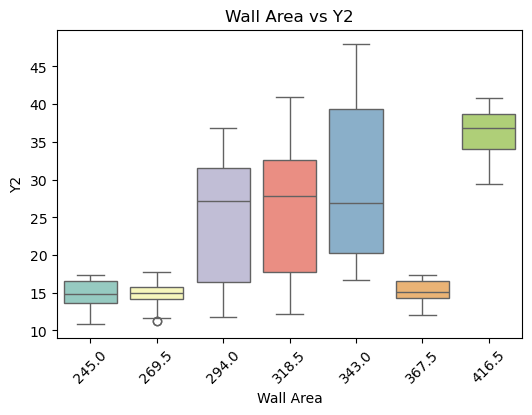

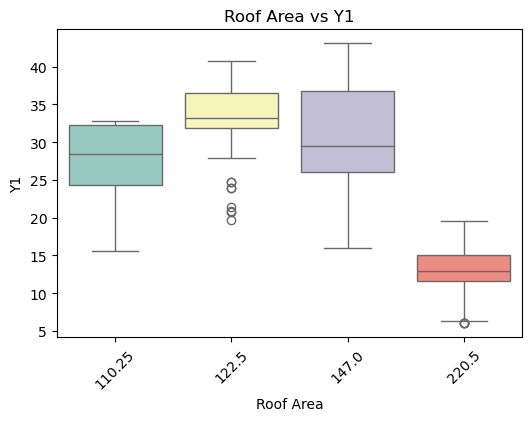

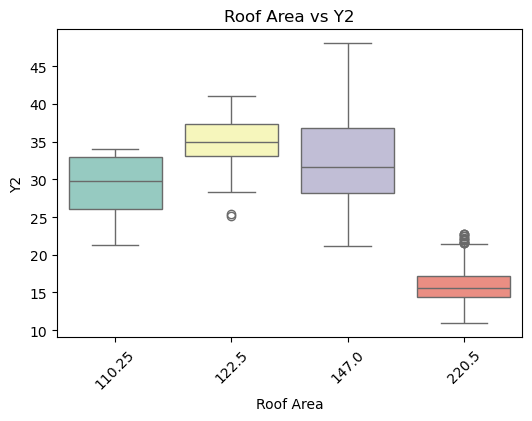

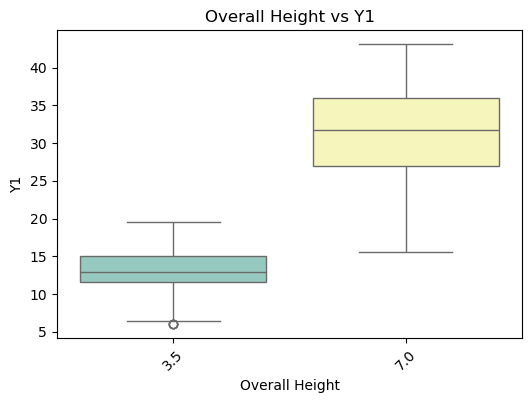

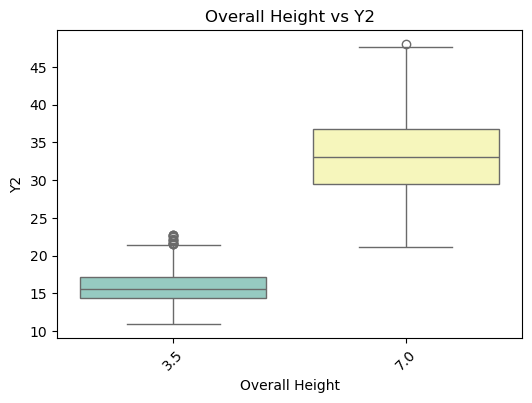

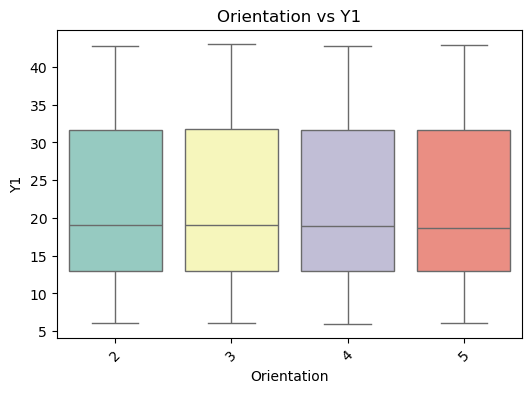

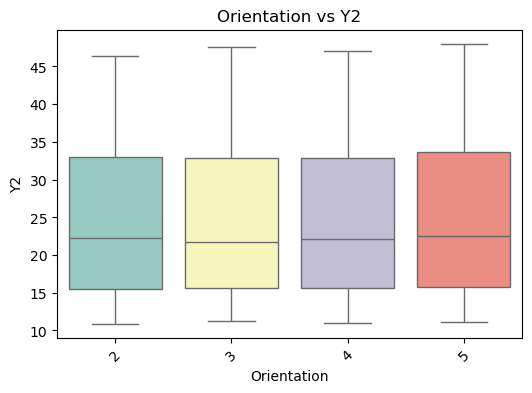

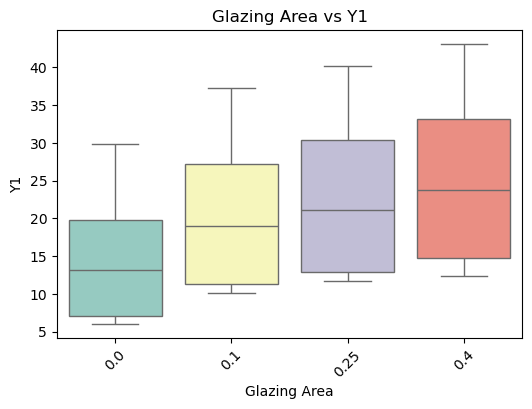

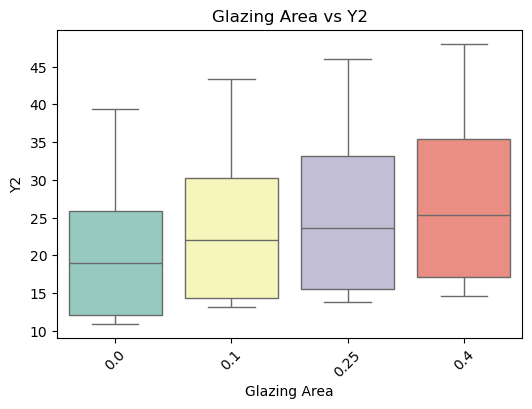

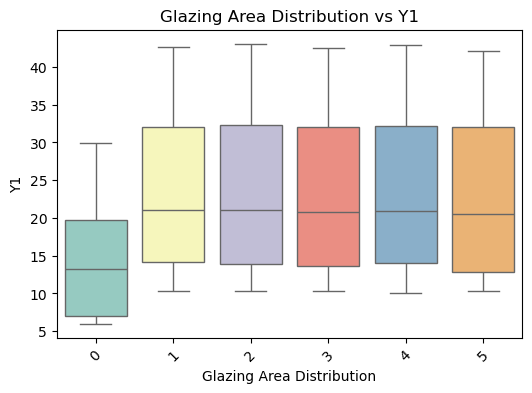

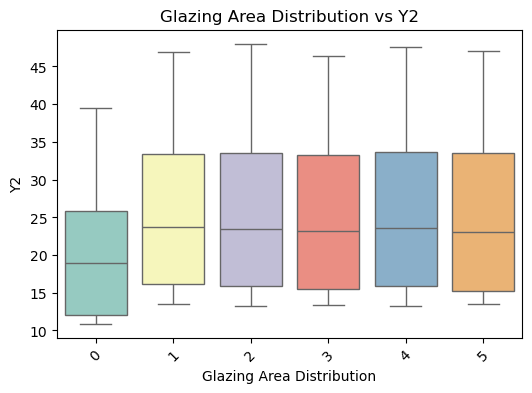

In [16]:
for col in categorical_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df, x=col, y="Y1", palette="Set3")
    plt.title(f"{col} vs Y1")
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(6,4))
    sns.boxplot(data=df, x=col, y="Y2", palette="Set3")
    plt.title(f"{col} vs Y2")
    plt.xticks(rotation=45)
    plt.show()

In [17]:
#columns_X =['Roof Area', 'Overall Height', 'Orientation', 'Glazing Area','Glazing Area Distribution','Relative Compactness', 'Surface Area', 'Wall Area']

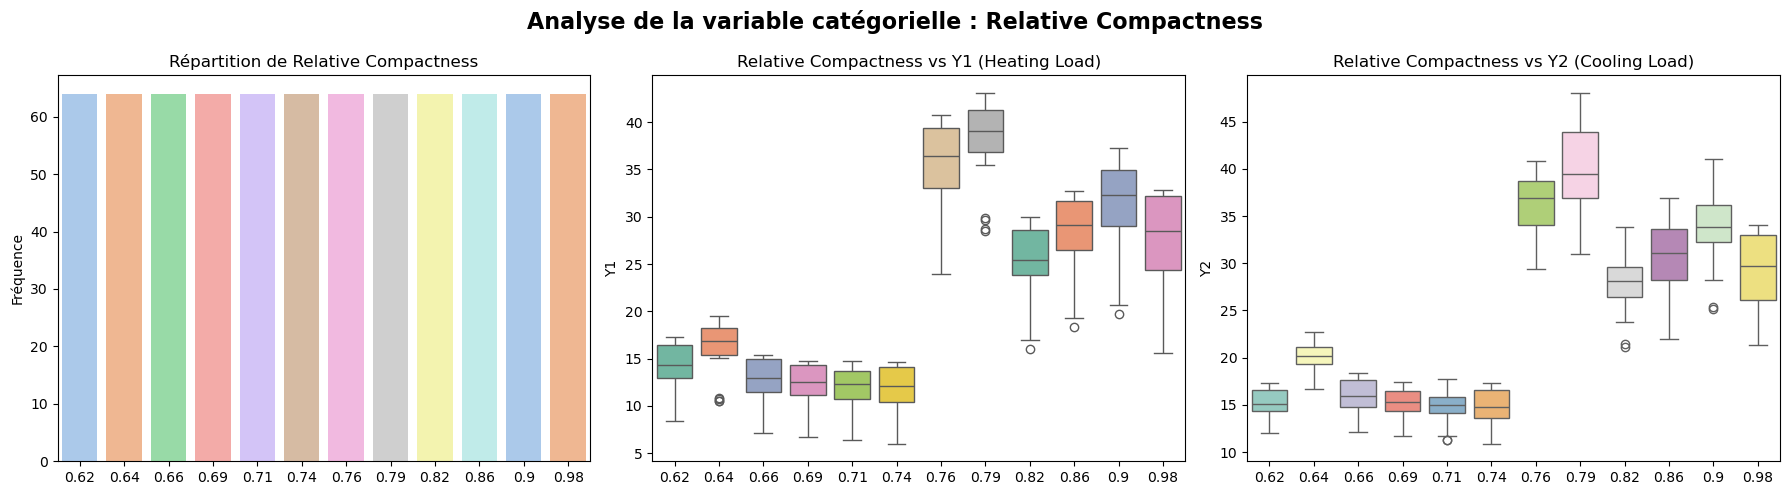

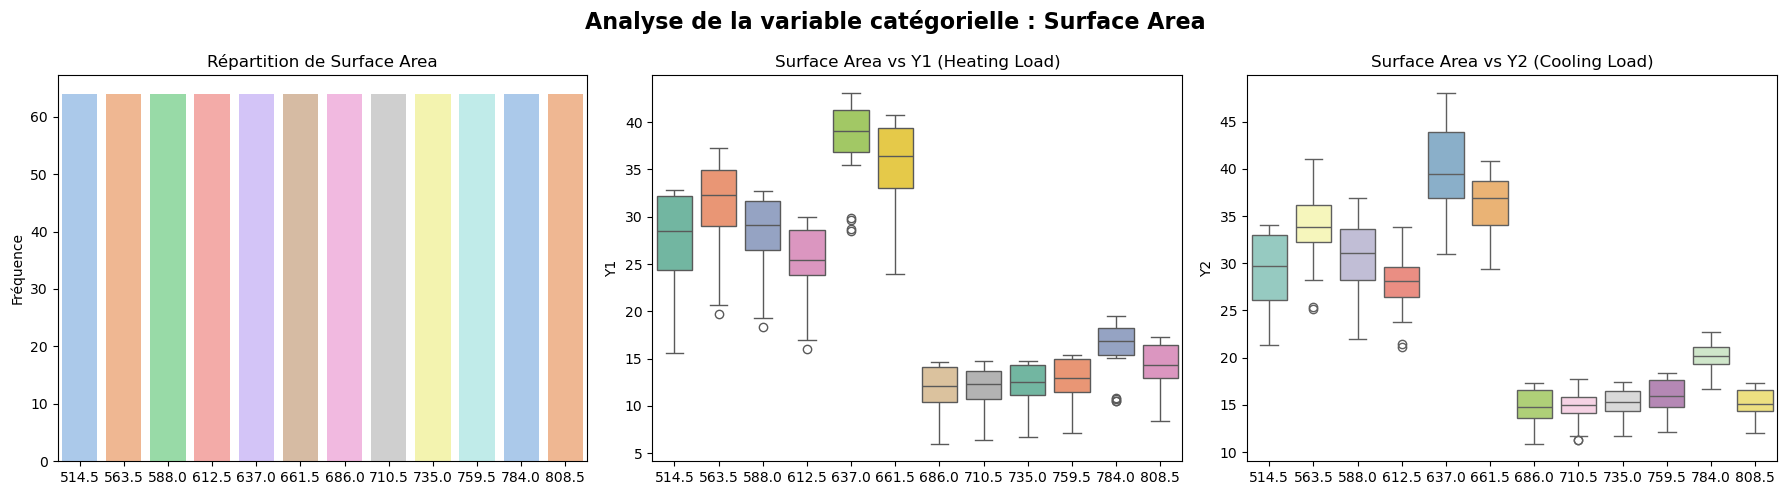

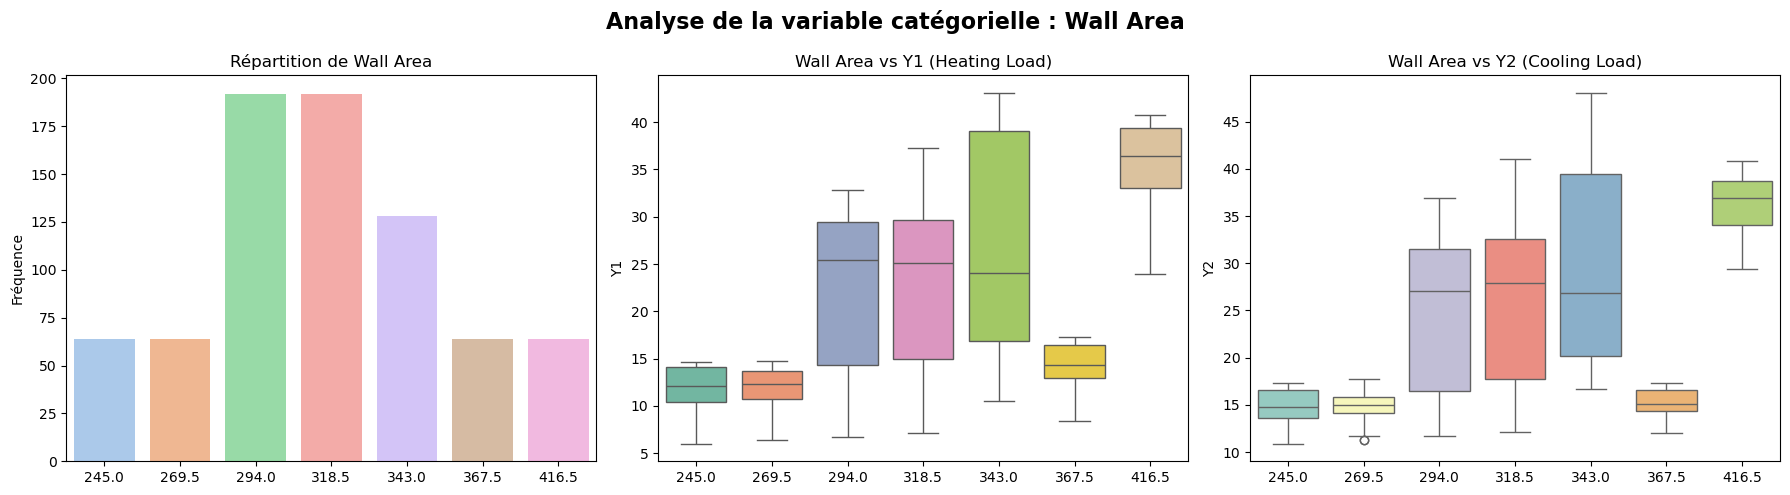

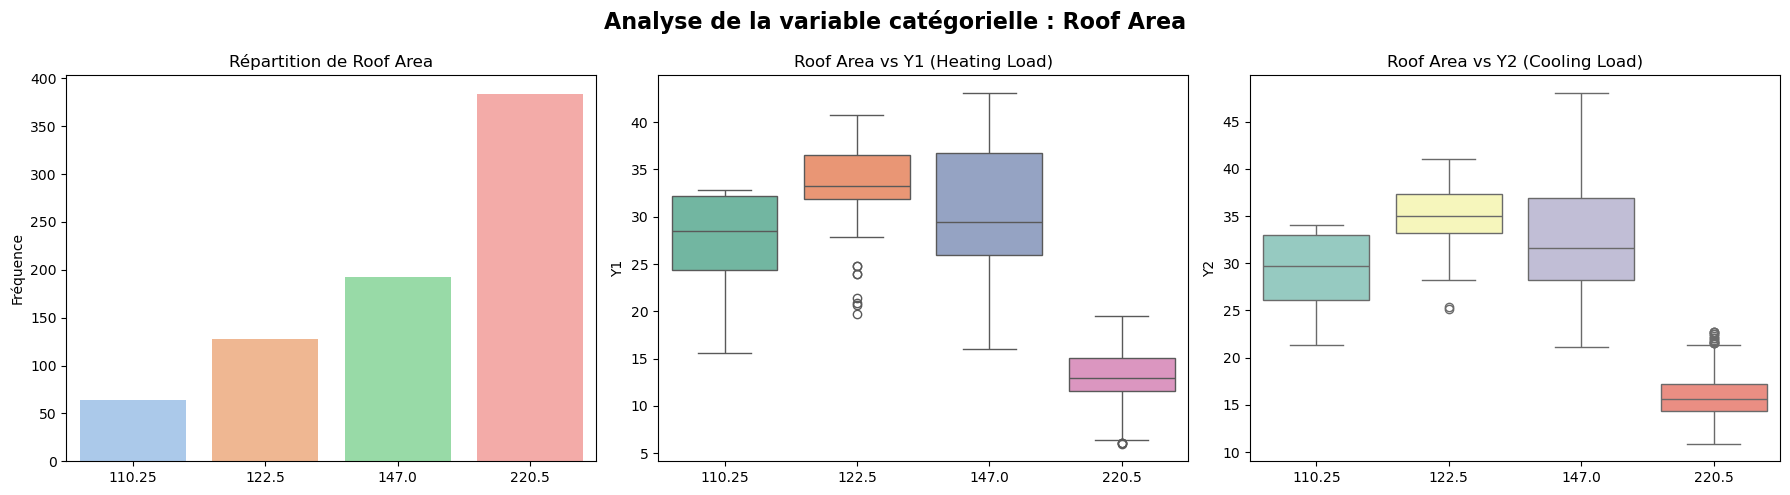

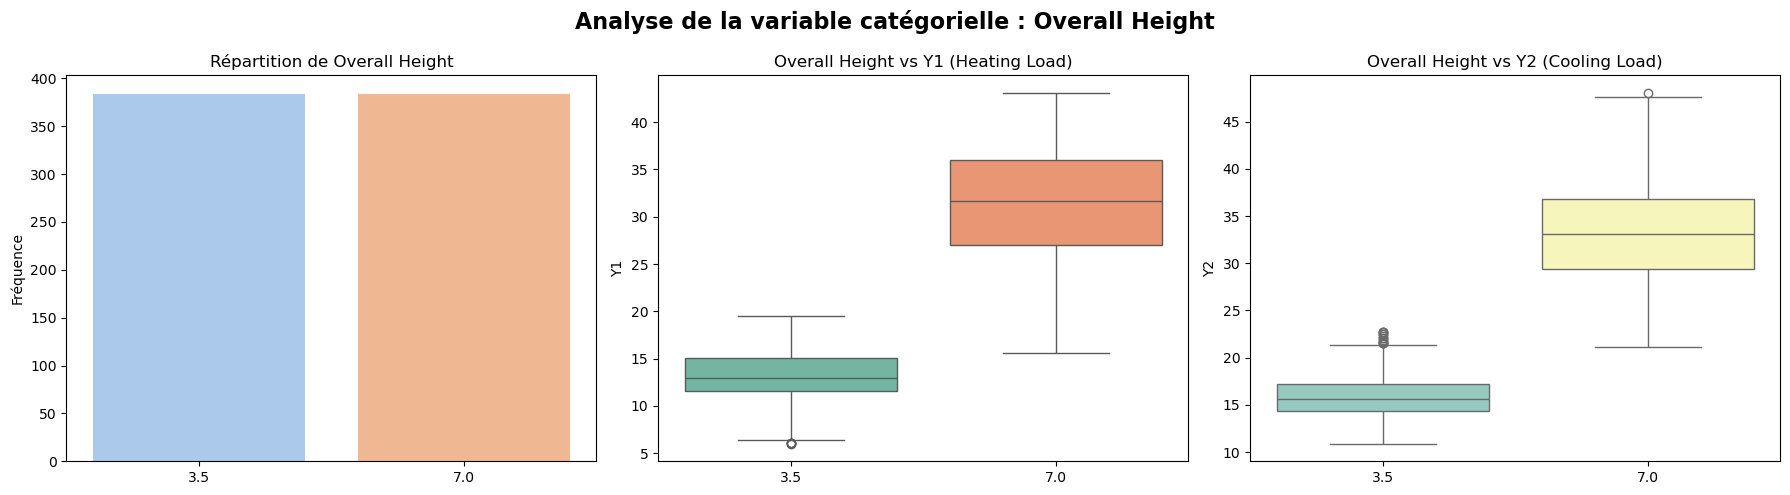

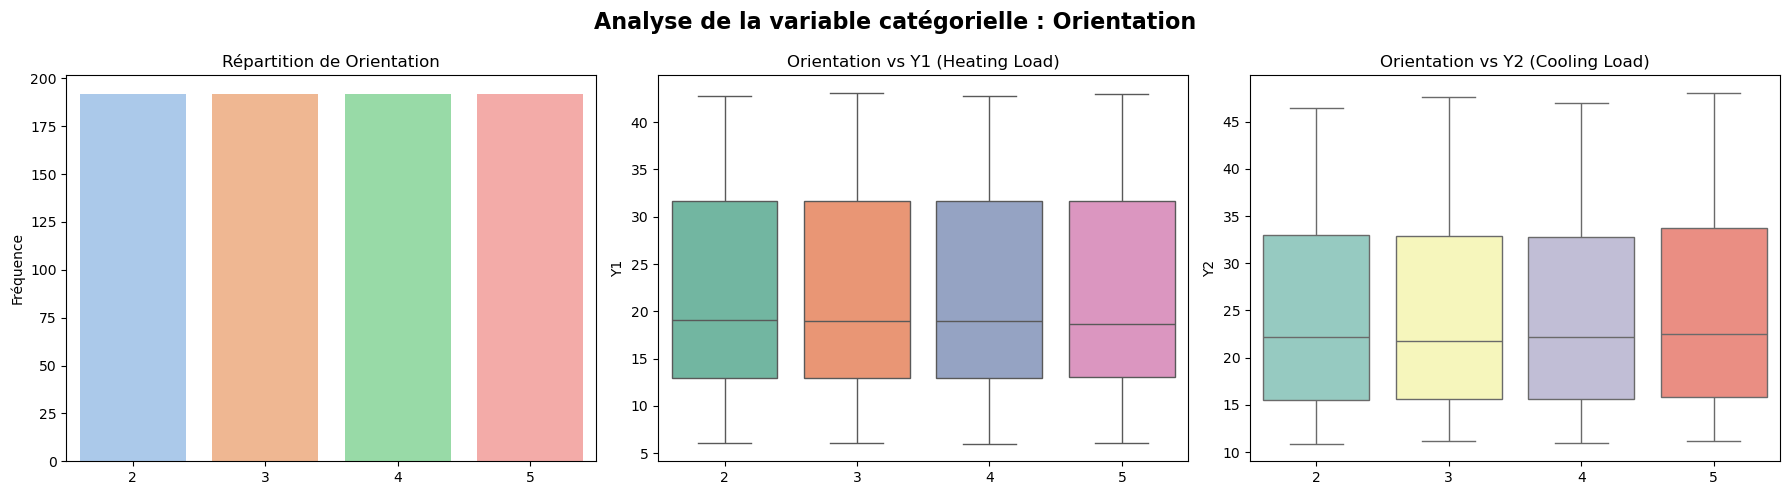

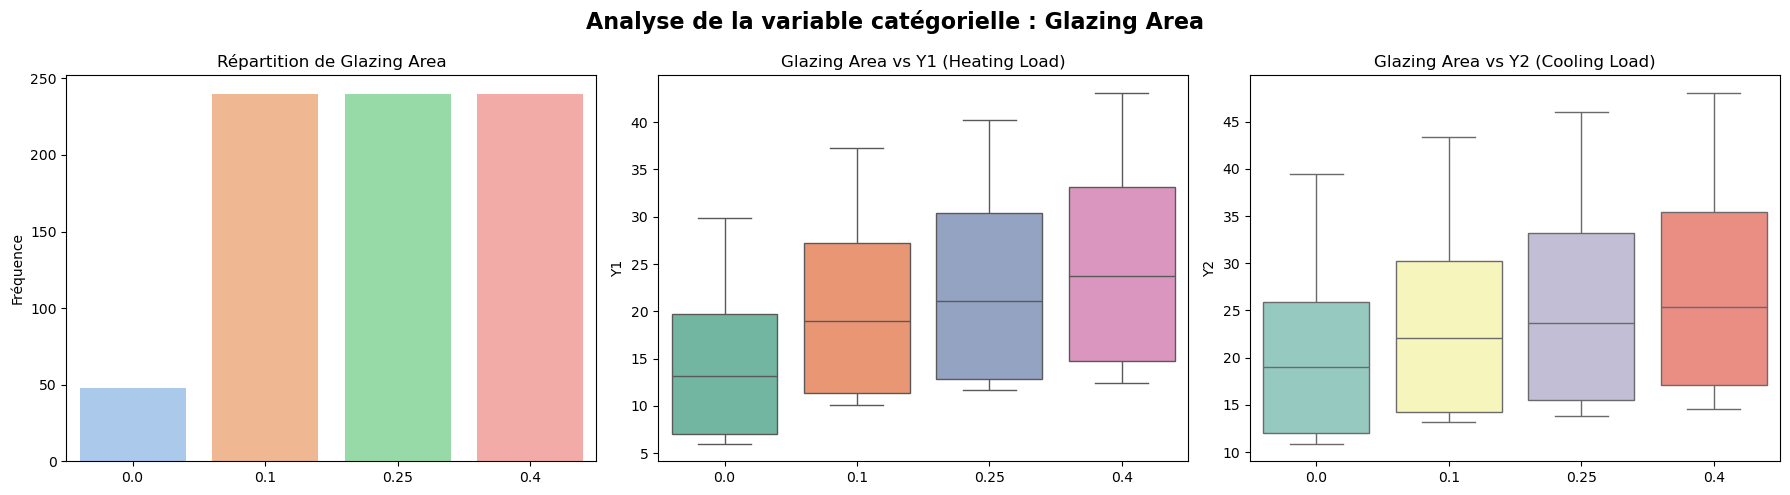

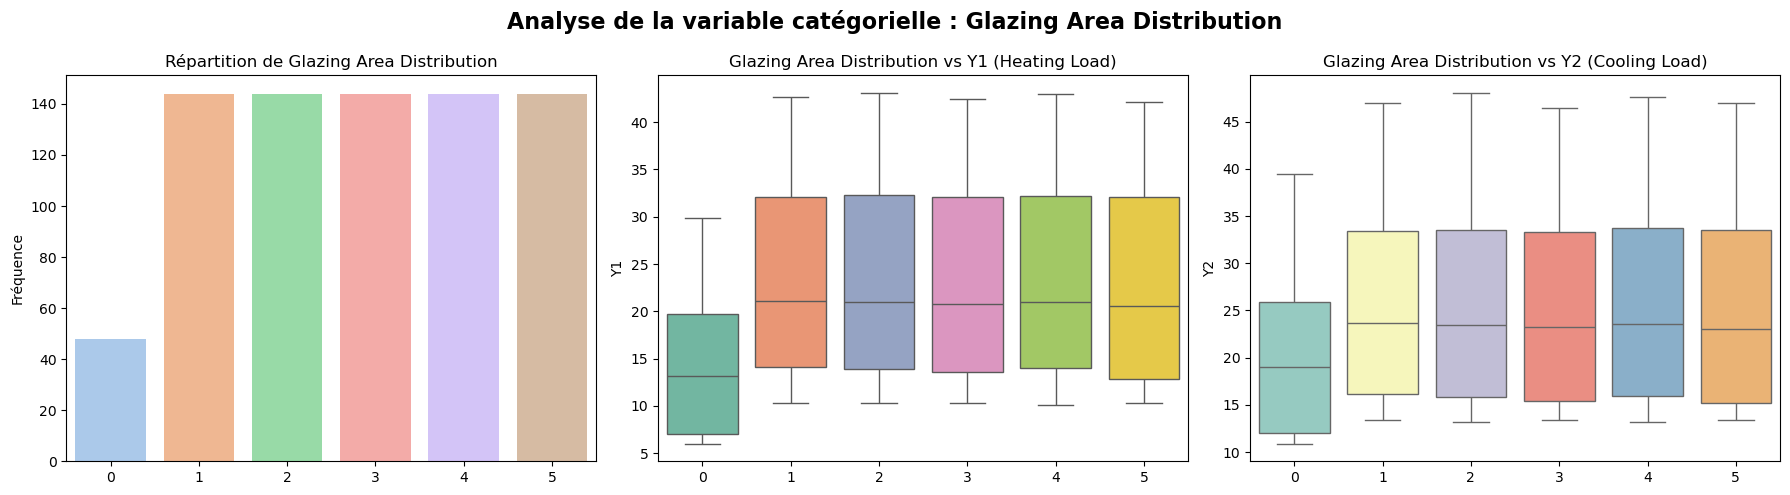

In [18]:
# boucle sur chaque variable catégorielle

for col in categorical_cols:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"Analyse de la variable catégorielle : {col}", fontsize=16, fontweight='bold')
    
    # 1️⃣ Countplot
    sns.countplot(data=df, x=col, ax=axes[0], palette="pastel")
    axes[0].set_title(f"Répartition de {col}")
    axes[0].set_xlabel("")
    axes[0].set_ylabel("Fréquence")
    
    # 2️⃣ Boxplot vs Y1
    sns.boxplot(data=df, x=col, y='Y1', ax=axes[1], palette="Set2")
    axes[1].set_title(f"{col} vs Y1 (Heating Load)")
    axes[1].set_xlabel("")
    axes[1].set_ylabel("Y1")
    
    # 3️⃣ Boxplot vs Y2
    sns.boxplot(data=df, x=col, y='Y2', ax=axes[2], palette="Set3")
    axes[2].set_title(f"{col} vs Y2 (Cooling Load)")
    axes[2].set_xlabel("")
    axes[2].set_ylabel("Y2")
    
    plt.tight_layout()
    plt.show()

#  Interprétation variable par variable (détaillée)


## 1. **Roof Area (Surface du toit)**

 Surface horizontale qui couvre le bâtiment, donc directement liée aux échanges thermiques par la toiture.

### Résultats observés :

* **Petites toitures (110.25, 147)** → Y1 (chauffage) modéré (24–36), Y2 (refroidissement) modéré (27–33).
* **Toiture moyenne (122.5)** → consommation **la plus élevée** (Y1 : 32–36, Y2 : 34–37).
* **Très grande toiture (220.5)** → consommation **très basse** (Y1 : 11.5–14, Y2 : 14–17).

### Interprétation :

* Les **très grandes toitures (220.5)** semblent associées à une conception plus performante → probablement meilleure isolation ou bâtiments plus compacts.
* Les **toitures moyennes (\~122.5)** représentent les cas les plus inefficaces.
* Les petites toitures restent intermédiaires.

 **En pratique** : dans ce dataset, une **grande toiture ne veut pas dire grandes pertes**. Au contraire, cela traduit une conception plus favorable à l’économie d’énergie.


## 2. **Overall Height (Hauteur totale)**

 Mesure verticale (3.5 m ou 7 m). Directement proportionnelle au **volume d’air à chauffer ou refroidir**.

### Résultats observés :

* **3.5 m** → très faibles besoins (Y1 : 11.5–15, Y2 : 14–17.5).
* **7 m** → besoins élevés (Y1 : 26–35, Y2 : 28–37).

### Interprétation :

* L’effet est **massif** : doubler la hauteur **double presque la consommation énergétique**.
* Plus le bâtiment est haut, plus le volume augmente, et donc plus d’énergie est nécessaire pour maintenir la température.

 **En pratique** :

* Les bâtiments **bas (3.5m)** sont beaucoup plus performants.
* Les bâtiments **hauts (7m)** sont défavorables → conception à éviter si l’objectif est de réduire les besoins énergétiques.



## 3. **Orientation (Nord, Est, Sud, Ouest – codée 2, 3, 4, 5)**

 L’angle d’exposition au soleil pourrait influencer les apports solaires.

### Résultats observés :

* Toutes les orientations présentent des charges similaires :

  * Chauffage : \~13–32.
  * Refroidissement : \~16–34.
* Aucune tendance claire ni différence marquée.

### Interprétation :

* L’**orientation n’a pas d’impact significatif** dans ce dataset.
* Cela peut être dû à des hypothèses de simulation simplifiées (par ex. vitrage homogène), ou au fait que d’autres variables comme la compacité et la surface murale dominent l’effet.

 **En pratique** : l’orientation n’est **pas un facteur explicatif fort** dans cette étude, contrairement à ce qu’on pourrait attendre dans un vrai contexte urbain.



## 4. **Glazing Area (Surface vitrée : 0%, 10%, 25%, 40%)**

 Taux de vitrage (fenêtres / surface de façade).

### Résultats observés :

* **0% vitrage** → charges basses.
* **10–25% vitrage** → charges plus hautes.
* **40% vitrage** → charges les plus élevées (chauffage et refroidissement).

### Interprétation :

* Le vitrage dégrade fortement les performances :

  * En hiver → plus de pertes thermiques (mauvaise isolation du verre par rapport au mur).
  * En été → plus de chaleur qui rentre (effet de serre).
* Plus le vitrage augmente, plus l’énergie nécessaire croît.

 **En pratique** :

* Limiter le **taux de vitrage** est une stratégie clé.
* Les bâtiments **très vitrés (40%)** sont très énergivores et donc peu durables.



## 5. **Glazing Area Distribution (répartition du vitrage : 0 à 5)**

 Décrit la façon dont les fenêtres sont réparties sur les façades.

### Résultats observés :

* **Distribution 0 (répartition uniforme ?)** → charges très faibles (Y1 : 5–19.5, Y2 : 12.5–26).
* **Distributions 1–5 (concentration sur certaines façades)** → charges nettement plus hautes (Y1 : 14–32, Y2 : 17–33).

### Interprétation :

* Quand le vitrage est **uniformement réparti (0)** → meilleure efficacité énergétique.
* Quand il est **concentré (1–5)** → déséquilibre thermique → pertes ou gains excessifs.

 **En pratique** :

* Non seulement la quantité de vitrage, mais aussi sa **répartition** joue un rôle majeur.
* **Uniformité = efficacité**.



## 6. **Relative Compactness (RC : 0.62 à 0.98)**

 Indice de compacité (rapport surface/volume). Plus RC est proche de 1, plus le bâtiment est compact.

### Résultats observés :

* **Valeurs hautes (0.76–0.98)** → charges généralement élevées (RC=0.79 et 0.9 très hauts, RC=0.98 un peu plus bas).
* **Valeurs basses (0.62–0.74)** → charges plus faibles, avec une décroissance progressive jusqu’à 0.71, puis légère remontée à 0.74.

### Interprétation :

* Contrairement à la théorie (où compacité élevée = efficacité), ici **les bâtiments compacts consomment parfois plus**.
* Cela indique des **interactions fortes** avec d’autres variables (ex. vitrage, surface).

 **En pratique** :

* La compacité seule ne suffit pas → il faut l’analyser en lien avec toiture, murs et vitrages.



## 7. **Surface Area (514.5 à 808.5)**

 Surface totale de l’enveloppe externe.

### Résultats observés :

* **514.5–661.5** → charges élevées, surtout pour 637 et 563.
* **686–808.5** → charges plus faibles.

### Interprétation :

* Paradoxalement, les **surfaces intermédiaires consomment plus** que les très grandes.
* Cela s’explique par une meilleure **compacité relative** des bâtiments à grande surface (mieux proportionnés).

 **En pratique** :

* L’effet n’est pas linéaire → les grands bâtiments (>686) peuvent être **plus économes** que les moyens.



## 8. **Wall Area (245 à 416.5)**

 Surface totale des murs verticaux.

### Résultats observés :

* **Petits murs (245, 269.5, 367.5)** → charges faibles (367.5 un peu plus haut).
* **Grands murs (294, 318.5, 343, 416.5)** → charges élevées, surtout 343 et 416.5.

### Interprétation :

* Plus de murs = plus de déperditions → donc consommation ↑.
* Exception : 367.5 (valeur “basse” mais déjà assez énergivore).

 **En pratique** :

* Réduire la **surface murale exposée** est essentiel.
* Les très grands murs sont fortement défavorables.



#  Conclusion finale (détaillée)

 Les 8 variables agissent à 2 niveaux :

### 1. **Variables les plus déterminantes**

* **Overall Height** → effet massif, les bâtiments hauts consomment beaucoup plus.
* **Glazing Area & Distribution** → le vitrage (quantité + répartition) est un **levier clé**.
* **Wall Area** → plus de surface murale = consommation en forte hausse.

### 2. **Variables avec effet conditionnel**

* **Relative Compactness** → influence forte mais dépend de la combinaison avec les autres (pas linéaire).
* **Surface Area** → grandes surfaces peuvent être **paradoxalement économes** si la compacité est favorable.
* **Roof Area** → très grandes toitures réduisent la consommation, les moyennes sont les pires cas.

### 3. **Variables peu explicatives**

* **Orientation** → pas d’effet notable dans ce dataset.



 **Synthèse générale** :

* L’efficacité énergétique est **multifactorielle** : elle dépend de la **géométrie (RC, hauteur, surface, murs, toiture)** ET des **ouvertures (vitrage, répartition)**.
* Les **mauvais cas** sont typiquement :

  * bâtiments hauts (7m),
  * avec beaucoup de vitrage (40%) concentré sur une façade,
  * compacité mal optimisée (RC élevé mais surface murale importante).
* Les **bons cas** sont :

  * bâtiments bas (3.5m),
  * avec peu de vitrage (0–10%), uniformément réparti,
  * grandes toitures bien isolées,
  * surfaces bien proportionnées.

 **En termes de conception** : pour réduire la consommation énergétique, il faut viser une **hauteur réduite, peu de vitrage uniformément réparti, des surfaces bien dimensionnées et peu de murs exposés**.

# **Détection d’outliers**

# **Récapitulatif clair** pour l’étape **détection d’outliers**.


##  Variables concernées par la détection d’outliers

###  **À analyser :**

* **Y1 (Heating Load)**
* **Y2 (Cooling Load)**

 Ce sont les **seules variables numériques continues**.

* Elles peuvent prendre un large éventail de valeurs réelles.
* Les méthodes classiques comme **IQR (Interquartile Range)** et **Z-Score** sont adaptées.
* Objectif : détecter si certaines maisons ont des consommations de chauffage/refroidissement **anormalement élevées ou basses**.



##  Variables non concernées par la détection d’outliers

###  **Numériques discrètes ordonnées (traitées comme catégorielles ordinales)**

* `Relative Compactness`
* `Surface Area`
* `Wall Area`

 Pourquoi on **n’applique pas** IQR/Z-score ?

* Ces variables prennent seulement **quelques valeurs fixes** (ex : 245.0, 269.5, 294.0, …).
* Chaque modalité représente une configuration architecturale bien définie, pas une valeur continue mesurable.
* Considérer une modalité comme "outlier" n’a **aucun sens** car toutes sont légitimes dans le jeu de données.



###  **Catégorielles nominales (pas d’ordre, valeurs qualitatives)**

* `Orientation`
* `Glazing Area`
* `Glazing Area Distribution`
* `Overall Height`
* `Roof Area`

 Pourquoi on **n’applique pas** IQR/Z-score ?

* Ce sont des **modalités qualitatives** (ex : Orientation = Nord, Est, Sud, Ouest).
* Pas de notion de "distance" entre les modalités.
* Un "outlier" n’existe pas ici : toutes les modalités sont valides.



##  **Résumé final**

* **Outliers possibles → Y1, Y2** 
* **Pas d’outliers (traitées comme catégories) → Relative Compactness, Surface Area, Wall Area, Orientation, Glazing Area, Glazing Area Distribution, Overall Height, Roof Area** 

##  Détection avec la méthode IQR

 **Principe** :

* On calcule le **Q1 (25e percentile)** et le **Q3 (75e percentile)**.
* On définit l’intervalle interquartile **IQR = Q3 – Q1**.
* Seuils :

  * Borne inférieure = Q1 – 1.5 × IQR
  * Borne supérieure = Q3 + 1.5 × IQR
* Toute valeur **hors de ces bornes** = *outlier*.

###  Interprétation IQR attendue :

* `Nb_outliers = 0` → aucune valeur extrême détectée.

* `Nb_outliers > 0` → certaines maisons ont une charge très différente des autres → à analyser au cas par cas.

###  Interprétation Z-score attendue :

* `Nb_outliers = 0` → toutes les valeurs sont dans la plage attendue.
* `Nb_outliers > 0` → valeurs extrêmes par rapport à la moyenne (beaucoup plus ou moins élevées).

In [19]:
from scipy import stats

# Méthode IQR
def detect_outliers_iqr(df, var):
    Q1 = df[var].quantile(0.25)
    Q3 = df[var].quantile(0.75)
    IQR = Q3 - Q1
    
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    outliers = df[(df[var] < lower) | (df[var] > upper)][var]
    
    return {
        "Variable": var,
        "Q1": Q1, "Q3": Q3, "IQR": IQR,
        "Lower_bound": lower,
        "Upper_bound": upper,
        "Nb_outliers": outliers.shape[0],
        "Outlier_indices": outliers.index.tolist(),
        "Outlier_values": outliers.values
    }

# Méthode Z-Score
def detect_outliers_zscore(df, var, threshold=3):
    z_scores = np.abs(stats.zscore(df[var]))
    outliers = df[z_scores > threshold][var]
    
    return {
        "Variable": var,
        "Mean": df[var].mean(),
        "Std": df[var].std(),
        "Threshold": threshold,
        "Nb_outliers": outliers.shape[0],
        "Outlier_indices": outliers.index.tolist(),
        "Outlier_values": outliers.values
    }


##  Détection avec la méthode Z-Score

 **Principe** :

* On calcule le score standardisé :

$$
Z = \frac{x - \mu}{\sigma}
$$

* Si |Z| > 3 → considéré comme un outlier (seuil usuel).

In [20]:
# Supposons qu’on veut tester sur Y1 et Y2
for col in ["Y1", "Y2"]:
    print("==== IQR ====")
    print(detect_outliers_iqr(df, col))
    print("\n==== Z-Score ====")
    print(detect_outliers_zscore(df, col))
    print("\n")


==== IQR ====
{'Variable': 'Y1', 'Q1': np.float64(12.9925), 'Q3': np.float64(31.6675), 'IQR': np.float64(18.675), 'Lower_bound': np.float64(-15.020000000000003), 'Upper_bound': np.float64(59.68000000000001), 'Nb_outliers': 0, 'Outlier_indices': [], 'Outlier_values': array([], dtype=float64)}

==== Z-Score ====
{'Variable': 'Y1', 'Mean': np.float64(22.307200520833334), 'Std': 10.090195732006162, 'Threshold': 3, 'Nb_outliers': 0, 'Outlier_indices': [], 'Outlier_values': array([], dtype=float64)}


==== IQR ====
{'Variable': 'Y2', 'Q1': np.float64(15.620000000000001), 'Q3': np.float64(33.1325), 'IQR': np.float64(17.5125), 'Lower_bound': np.float64(-10.648749999999996), 'Upper_bound': np.float64(59.40125), 'Nb_outliers': 0, 'Outlier_indices': [], 'Outlier_values': array([], dtype=float64)}

==== Z-Score ====
{'Variable': 'Y2', 'Mean': np.float64(24.58776041666667), 'Std': 9.513305562326163, 'Threshold': 3, 'Nb_outliers': 0, 'Outlier_indices': [], 'Outlier_values': array([], dtype=float64)}

## Comparaison des deux méthodes

* **IQR** → robuste aux distributions non normales (quartiles).
* **Z-Score** → efficace si les données suivent une loi normale.
* Si les deux méthodes détectent les mêmes points → ce sont de **vrais outliers**.
* Si seul Z-score détecte mais pas IQR → cela peut être dû à la **queue de distribution**.
* Si seul IQR détecte → cela peut être dû à une **distribution asymétrique**.



 **Conclusion attendue** :

* On saura si Y1 et Y2 contiennent des valeurs extrêmes.
* Ensuite, on décidera :

  * soit de les **conserver** (si elles représentent des cas réels valides),
  * soit de les **corriger ou supprimer** (si elles sont dues à des erreurs ou trop rares pour être utiles).

#  Les deux méthodes d’outliers : IQR vs Z-Score



## 1. **Méthode IQR (Interquartile Range)**

On regarde la **dispersion des données** à travers les quartiles (**Q1 = 25%**, **Q3 = 75%**) et on considère comme *outliers* les points **trop loin** de l’intervalle central.

* **Formule** :

  * Intervalle interquartile = `IQR = Q3 - Q1`
  * Borne inférieure = `Q1 - 1.5 × IQR`
  * Borne supérieure = `Q3 + 1.5 × IQR`

* **Avantage** : **Robuste** → il n’est pas influencé par les valeurs extrêmes car basé sur les **quartiles**.

* **Inconvénient** : Ne tient pas compte de la forme globale de la distribution (gaussienne ou non).


## 2. **Méthode Z-Score**

On suppose que les données suivent une **loi normale (distribution en cloche)**.
On calcule la **distance de chaque valeur à la moyenne**, normalisée par l’écart-type.

* **Formule** :

  $$
  Z = \frac{X - \mu}{\sigma}
  $$

  Si |Z| > 3 → outlier (plus de 3 écarts-types de la moyenne).

* **Avantage** : Efficace si les données sont **gaussiennes**.

* **Inconvénient** : Si les données sont très **asymétriques** ou ont de **grosses queues**, il détecte trop ou pas assez d’outliers.

### Exemple :

Avec les mêmes données :

```
[10, 11, 12, 12, 13, 14, 15, 100]
```

* Moyenne ≈ 23.4, Écart-type ≈ 29.2
* Z-score de 100 = (100 - 23.4) / 29.2 ≈ 2.6
* Résultat : `100` n’est **pas détecté** (car 2.6 < 3).

 Ici, Z-score **échoue** à détecter l’outlier car la moyenne a été *tirée vers le haut* par la valeur extrême.



## 3. **Comparaison directe**

| Cas                                                                | IQR          | Z-Score    | Explication                                          |
| ------------------------------------------------------------------ | ------------ | ---------- | ---------------------------------------------------- |
| **Distribution normale** (données en cloche, sans forte asymétrie) | Ok           | Très bon   | Les deux détectent les mêmes outliers                |
| **Distribution asymétrique (skewed)**                              | Bon          | Mauvais    | Z-score peut rater des outliers car moyenne déplacée |
| **Petits échantillons**                                            | Fiable       | Peu fiable | Z-score dépend trop de la moyenne/écart-type         |
| **Présence de valeurs extrêmes fortes**                            | Très robuste | Fragile    | Z-score se fait « piéger » par les extrêmes          |



## 4. **En pratique**

* Si on **ne sais pas** si ses données sont normales → utilise **IQR** (plus robuste).
* Si on ne sais pas que ses données sont **gaussiennes** (exemple : erreurs de mesure, scores d’examen) → Z-score est plus précis.
* Si les deux méthodes détectent les mêmes points → ce sont de **vrais outliers sûrs**.


**Résumé clair :**

* **IQR** : fonctionne toujours, robuste, utile pour **données non normales** (asymétriques, multimodales, distributions bizarres).
* **Z-Score** : meilleur si les données suivent une **loi normale**, mais fragile sinon.

#  Résultats de la détection d’outliers

## 1. **Méthode IQR (Y1 et Y2)**

* **Y1** :

  * Q1 ≈ 12.99, Q3 ≈ 31.67 → IQR ≈ 18.67
  * Seuils : \[-15.02, 59.68]
  * **Aucun outlier détecté** car toutes les valeurs sont dans cet intervalle.

* **Y2** :

  * Q1 ≈ 15.62, Q3 ≈ 33.13 → IQR ≈ 17.51
  * Seuils : \[-10.64, 59.40]
  * **Aucun outlier détecté**.

 L’IQR conclut que **toutes les observations sont cohérentes** et proches de la majorité des données.



## 2. **Méthode Z-Score (Y1 et Y2)**

* **Y1** :

  * Moyenne ≈ 22.3, σ ≈ 10.1
  * Aucun point n’a |Z| > 3
  * **Pas d’outlier**.

* **Y2** :

  * Moyenne ≈ 24.6, σ ≈ 9.5
  * Aucun point n’a |Z| > 3
  * **Pas d’outlier**.

 Z-score confirme aussi qu’il n’existe pas de valeurs aberrantes fortes.



## 3. **Conclusion conjointe**

 **IQR et Z-Score s’accordent** :

* Ni Y1 (chauffage), ni Y2 (refroidissement) ne contiennent de valeurs aberrantes.
* Cela montre que le **dataset est bien construit et propre**, sans anomalies fortes.

 **Ce qui est important à retenir ici** :

* C’est un dataset **simulé (Energy Efficiency)**, généré de manière équilibrée → pas de valeurs "extrêmes" qui viendraient de mesures réelles ou erreurs humaines.
* Si c’était un dataset réel (par ex. capteurs ou factures énergétiques), on aurait pu détecter quelques outliers (ex : bâtiment mal saisi, valeur extrême due à une panne, etc.).


L’étape **outliers** est donc validée et on peut passer à la **prochaine étape** du projet.

 La suite logique :

 **Corrélations (Pearson & Spearman)** pour comprendre les liens entre Y1, Y2 et les autres variables.

#  Différence fondamentale entre **linéaire** (Pearson) et **monotone** (Spearman)

## 1) Corrélation de Pearson

* **Ce qu’elle mesure** : le degré de relation **linéaire** entre deux variables continues.
* **Formule** : c’est l’angle du nuage de points (covariance normalisée).
* **Hypothèse** : si X augmente de 1, alors Y change de **+a** ou **–a** *de manière constante*.
* **Limite** : si la relation n’est pas une **droite**, Pearson échoue.


## 2) Corrélation de Spearman

* **Ce qu’elle mesure** : le degré de relation **monotone** entre deux variables (croissante ou décroissante, pas forcément linéaire).
* **Comment ?** Transforme les données en **rangs** (1er, 2ème, …), puis calcule la corrélation de Pearson sur ces rangs.
* **Hypothèse** : seulement qu’il y a une tendance **ordre-conservatrice** (si X1 > X2, alors Y1 tend à > Y2).
* **Avantage** : robuste aux non-linéarités et aux distributions bizarres.


## Conclusion

* **Linéaire = un cas particulier de monotone**.

  * Si la relation est parfaitement linéaire croissante/décroissante → elle est aussi monotone.
  * Mais toutes les relations monotones ne sont pas linéaires.
* **Pearson** : mesure la **force de la droite d’ajustement**.
* **Spearman** : mesure si « **quand X monte, Y monte (ou descend) de façon régulière** », peu importe la forme.
* Dans ton dataset :

  * Beaucoup de relations sont **presque linéaires** (construction synthétique), donc **Pearson ≈ Spearman**.
  * Si on avais de vraies données du terrain avec des non-linéarités → les deux pourraient **diverger fortement**.

In [21]:
from scipy.stats import spearmanr

def correlation_analysis(df, target_vars, method="pearson"):
    """
    Calcule les corrélations entre Y1, Y2 et les autres variables
    - df : dataframe
    - target_vars : liste des colonnes cibles (ex: ['Y1','Y2'])
    - method : 'pearson' ou 'spearman'
    """
    results = {}
    for target in target_vars:
        corrs = {}
        for col in df.columns:
            if col != target:
                if method == "pearson":
                    corr = df[target].corr(df[col], method="pearson")
                elif method == "spearman":
                    corr, _ = spearmanr(df[target], df[col])
                corrs[col] = corr
        results[target] = corrs
    return pd.DataFrame(results)


In [22]:
# Supposons que ton dataframe s'appelle df
target_vars = ["Y1", "Y2"]

# Corrélations Pearson (adapté aux variables continues / discrètes ordonnées)
pearson_corr = correlation_analysis(df, target_vars, method="pearson")
print("=== Corrélations Pearson ===")
print(pearson_corr)

# Corrélations Spearman (adapté aux variables ordinales et catégorielles codées)
spearman_corr = correlation_analysis(df, target_vars, method="spearman")
print("=== Corrélations Spearman ===")
print(spearman_corr)


=== Corrélations Pearson ===
                                 Y1        Y2
Relative Compactness       0.622272  0.634339
Surface Area              -0.658120 -0.672999
Wall Area                  0.455671  0.427117
Roof Area                 -0.861828 -0.862547
Overall Height             0.889431  0.895785
Orientation               -0.002587  0.014290
Glazing Area               0.269841  0.207505
Glazing Area Distribution  0.087368  0.050525
Y2                         0.975862       NaN
Y1                              NaN  0.975862
=== Corrélations Spearman ===
                                 Y1        Y2
Relative Compactness       0.622135  0.651019
Surface Area              -0.622135 -0.651019
Wall Area                  0.471458  0.415991
Roof Area                 -0.804027 -0.803175
Overall Height             0.861283  0.864876
Orientation               -0.004163  0.017606
Glazing Area               0.322860  0.288904
Glazing Area Distribution  0.068343  0.046477
Y2                   

#  Lecture détaillée des 8 variables (corrélations vs Y1 & Y2)

> Barème rapide d’interprétation de |r| :
> **Très fort** ≥ 0.80 • **Fort** 0.60–0.79 • **Modéré** 0.30–0.59 • **Faible** < 0.30



## 1) Overall Height (hauteur totale)

* **Pearson** avec Y1/Y2 : **+0.889 / +0.896** (très fort)
* **Spearman** : **+0.861 / +0.865** (très fort)

**Sens du signe :** plus le bâtiment est haut (7 m vs 3,5 m), **plus les charges augmentent** (chauffage et clim).
**Pourquoi ?** Volume intérieur plus grand → plus d’air à chauffer/refroidir, plus de surfaces d’échange verticales.
**Implication pratique :** variable **clé** à garder dans tout modèle; elle explique **beaucoup** de variance à elle seule.



## 2) Roof Area (surface de toit)

* **Pearson** : **–0.862 / –0.863** (très fort)
* **Spearman** : **–0.804 / –0.803** (très fort)

**Sens du signe :** plus la surface de toit est grande, **plus les charges baissent**.
**Pourquoi, alors que ça peut sembler contre-intuitif ?** Dans ce dataset, une **grande surface de toit est typiquement associée à des bâtiments plus bas (3,5 m)** et à une emprise au sol plus large (donc **moins de hauteur** → or la hauteur est le **driver n°1** et elle est **positivement** corrélée aux charges). Autrement dit, *Roof Area* capte en creux « **bâtiment bas** ».
**Implication :** très prédictive, mais **colinéaire** avec *Overall Height*. À surveiller (VIF/colinéarité) dans un modèle.


## 3) Relative Compactness (compacité relative)

* **Pearson** : **+0.622 / +0.634** (fort)
* **Spearman** : **+0.622 / +0.651** (fort)

**Sens du signe :** plus la compacité est élevée, **plus** Y1/Y2 **augmentent** (dans ce dataset).
**Pourquoi (alors qu’on attend souvent l’inverse) ?** Ici, les variables de géométrie (**compacité, surfaces, mur/toit, hauteur**) sont **co-construites** dans une grille synthétique. *Relative Compactness* évolue de concert avec d’autres dimensions (ex : hauteur) qui **poussent** les charges à la hausse. Résultat : *RC* devient un **proxy** d’un **mix géométrique** qui, dans ces combinaisons, **augmente** les charges.
**Implication :** très informative, mais **fortement liée** aux autres géométries → ne pas l’interpréter isolément.



## 4) Surface Area (surface d’enveloppe)

* **Pearson** : **–0.658 / –0.673** (fort)
* **Spearman** : **–0.622 / –0.651** (fort)

**Sens du signe :** plus la surface d’enveloppe est grande, **plus les charges baissent** (ici).
**Pourquoi (paradoxe apparent) ?** Dans cette base, **grande surface** rime souvent avec **grand toit + faible hauteur** (bâtiment « étalé » à 3,5 m), et **la hauteur est le driver majeur à la hausse**. Le signal « bâtiment bas » l’emporte sur « plus de surface = plus d’échanges ».
**Implication :** variable très prédictive mais **colinéaire** avec *Roof Area* et *Overall Height*. Ne pas sur-interpréter le signe **sans contrôler la hauteur**.



## 5) Wall Area (surface des murs)

* **Pearson** : **+0.456 / +0.427** (modéré)
* **Spearman** : **+0.471 / +0.416** (modéré)

**Sens du signe :** plus de surface murale → **charges plus élevées**.
**Pourquoi ?** Les murs sont un **vecteur majeur de pertes/gains**. Même si le design global joue, l’effet « plus de mur = plus d’échanges » se voit encore (d’où le **+**).
**Implication :** utile, effet **physiquement plausible** et plus « direct » que *Surface Area* dans ce dataset.



## 6) Glazing Area (taux de vitrage)

* **Pearson** : **+0.270 / +0.208** (faible à modéré)
* **Spearman** : **+0.323 / +0.289** (modéré)

**Sens du signe :** plus de vitrage → **charges plus élevées** (pertes en hiver, apports solaires en été).
**Pourquoi Spearman > Pearson ?** Relation **monotone par paliers** (0%, 10%, 25%, 40%). Spearman (corrélation de rang) capte mieux ces **marches ordinales** que Pearson (linéarité).
**Implication :** effet réel mais **secondaire** vs géométrie/hauteur. À garder.



## 7) Glazing Area Distribution (répartition des vitrages)

* **Pearson** : **+0.087 / +0.051** (faible)
* **Spearman** : **+0.068 / +0.046** (faible)

**Sens du signe :** effet **très faible / quasi nul**.
**Pourquoi ?** La manière dont les vitrages sont répartis (codes 0–5) pèse **peu** au regard de la **quantité totale** de vitrage et de la **géométrie**.
**Implication :** variable **faible**; on peut la conserver, mais elle **n’apportera pas** grand-chose dans un modèle simple.



## 8) Orientation

* **Pearson** : **≈ 0** (–0.003 / +0.014)
* **Spearman** : **≈ 0** (–0.004 / +0.018)

**Sens du signe :** **aucun effet détectable**.
**Pourquoi ?** Le dataset est **équilibré** et les autres facteurs (hauteur, vitrage, géométrie) **éclipsent** l’orientation. De plus, le codage numérique 2/3/4/5 n’est **pas ordinal** (nominal), donc Pearson est **peu pertinent** conceptuellement; Spearman confirme **l’absence** de monotonie.
**Implication :** variable **non informative** ici.



#  Conclusion finale (ce qu’il faut retenir)

1. **Drivers majeurs (à très fort/fort impact)**

* **Overall Height** (**+** très fort) : plus haut = **plus de charges**.
* **Roof Area** (**–** très fort) : ici, *grand toit* ↔ *bâtiment bas* → **moins de charges**.
* **Relative Compactness** (**+** fort) & **Surface Area** (**–** fort) : effets **contraires** car ces variables **se codépendent** des choix de géométrie; leurs signes reflètent la **structure du dataset** (mix compacité/hauteur/surfaces), **pas une causalité isolée**.

2. **Effets secondaires mais plausibles**

* **Wall Area** (**+** modéré) : plus de surface murale → **plus d’échanges**.
* **Glazing Area** (**+** faible-modéré) : plus de vitrage → **charges ↑** (pertes/apports).

3. **Effets négligeables**

* **Glazing Area Distribution**, **Orientation** : impact **faible / nul**.

4. **Attention colinéarité**

* Les variables de géométrie (**Height, Roof Area, Surface Area, RC, Wall Area**) sont **fortement corrélées entre elles**. Pour bien isoler les effets :

  * calcule **VIF** / **corrélations inter-features**,
  * ou passe en **régression multiple** / **régression réguliarisée** (Ridge/Lasso),
  * ou regarde des **effets partiels** (partial correlations) en contrôlant la hauteur.

In [23]:
def plot_correlation_heatmap(df, method="pearson"):
    """
    Affiche le tableau des corrélations et un heatmap annoté.
    
    Paramètres
    ----------
    df : pd.DataFrame
        DataFrame contenant les variables numériques.
    method : str
        Méthode de corrélation ('pearson', 'spearman' ou 'kendall').
    """
    # 1. Calcul de la matrice de corrélation
    corr_matrix = df.corr(method=method)
    
    # 2. Affichage du tableau
    #
    #print("\n--- Matrice de corrélation (" + method + ") ---")
    #print(corr_matrix.round(2))
    
    # 3. Heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        corr_matrix, 
        annot=True,       # valeurs affichées
        cmap="coolwarm",  # couleurs
        center=0,         # 0 = couleur neutre
        fmt=".2f"
    )
    plt.title("Heatmap des corrélations (" + method + ")", fontsize=14)
    plt.show()

In [24]:
df.corr(method="pearson").round(2)

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Y1,Y2
Relative Compactness,1.00,-0.99,-0.20,-0.87,0.83,0.00,-0.00,-0.00,0.62,0.63
Surface Area,-0.99,1.00,0.20,0.88,-0.86,-0.00,0.00,0.00,-0.66,-0.67
Wall Area,-0.20,0.20,1.00,-0.29,0.28,-0.00,-0.00,0.00,0.46,0.43
Roof Area,-0.87,0.88,-0.29,1.00,-0.97,-0.00,-0.00,-0.00,-0.86,-0.86
Overall Height,0.83,-0.86,0.28,-0.97,1.00,0.00,0.00,-0.00,0.89,0.90
Orientation,0.00,-0.00,-0.00,-0.00,0.00,1.00,-0.00,-0.00,-0.00,0.01
Glazing Area,-0.00,0.00,-0.00,-0.00,0.00,-0.00,1.00,0.21,0.27,0.21
Glazing Area Distribution,-0.00,0.00,0.00,-0.00,-0.00,-0.00,0.21,1.00,0.09,0.05
Y1,0.62,-0.66,0.46,-0.86,0.89,-0.00,0.27,0.09,1.00,0.98
Y2,0.63,-0.67,0.43,-0.86,0.90,0.01,0.21,0.05,0.98,1.00


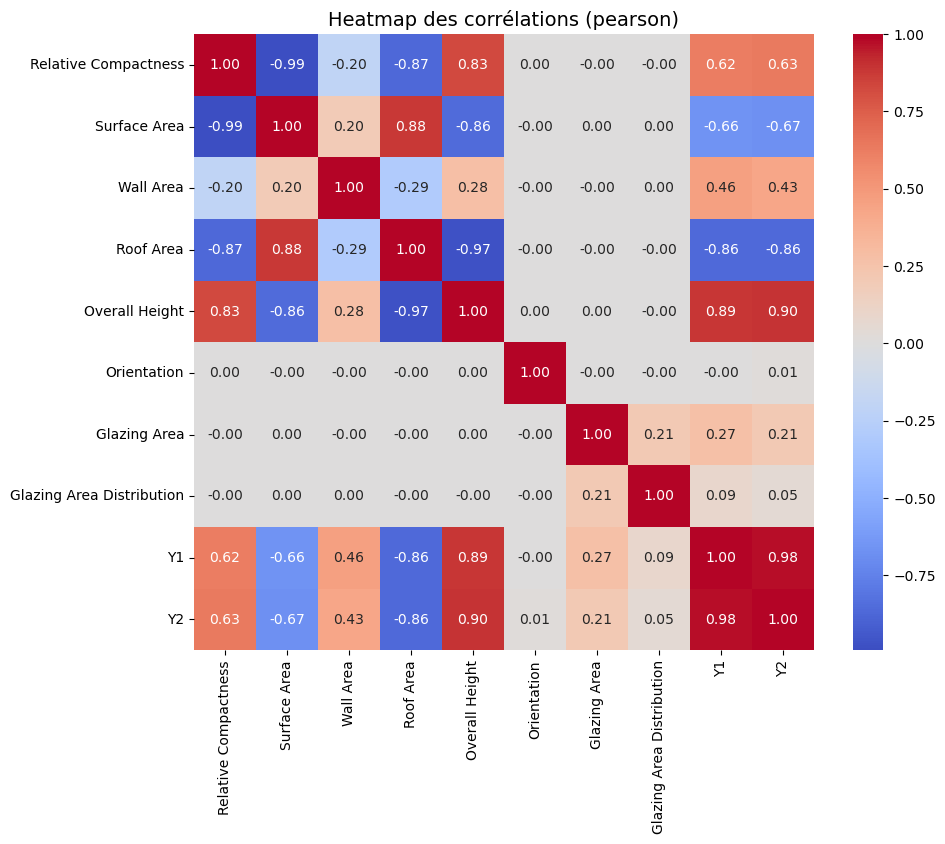

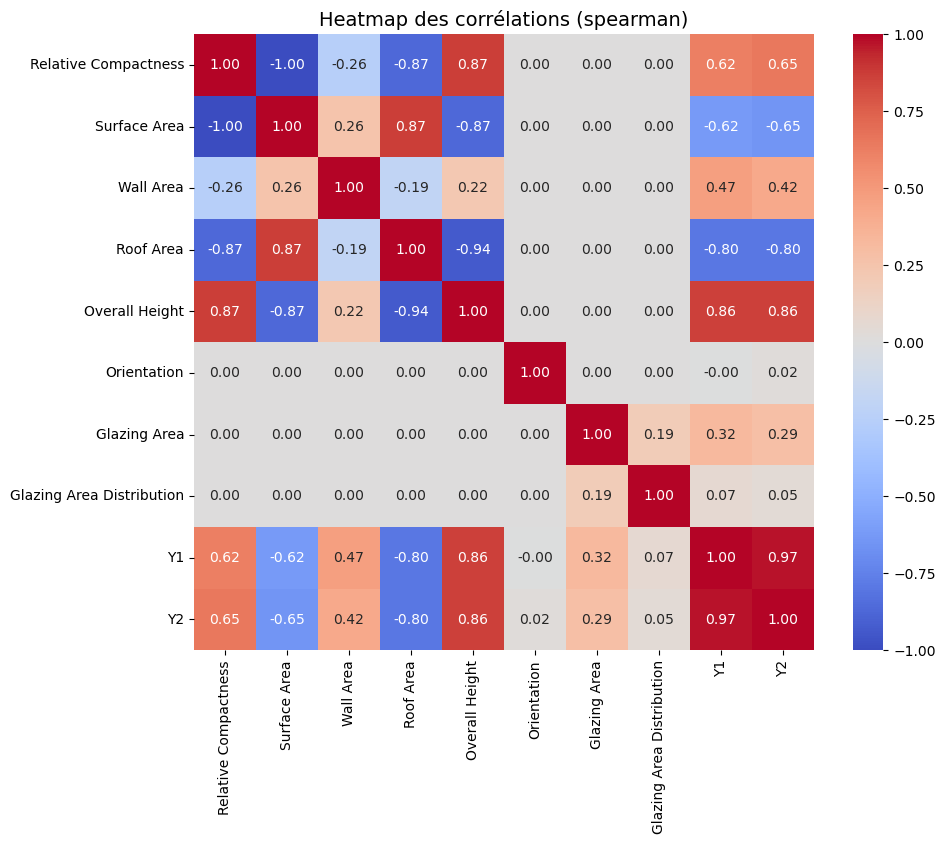

In [25]:
#plt.subplots(1, 2)
plot_correlation_heatmap(df,method="pearson")
plot_correlation_heatmap(df,method="spearman")

1. Ce que signifie la corrélation
2. Le **risque pour l’analyse/prédiction** (ex. colinéarité, redondance…)
3. Les **solutions possibles** (supprimer, combiner, transformer, etc.)



#  Interprétation + Risques + Solutions



## 1. **Relative Compactness ↔ Surface Area : r = −0.99**

* **Sens :** plus le bâtiment est compact, plus sa surface extérieure diminue.
* **Risque :** ces deux variables sont quasiment **parfaitement redondantes**. Inclure les deux dans un modèle va créer une **multicolinéarité forte** → coefficients instables.
* **Solution :**

  * Garder une seule des deux (ex : Relative Compactness qui est plus directement interprétable).
  * Ou bien utiliser une méthode régularisée (Ridge/Lasso) qui réduit ce problème.



## 2. **Roof Area ↔ Overall Height : r = −0.97**

* **Sens :** bâtiments hauts → petit toit ; bâtiments bas → grand toit.
* **Risque :** encore une **quasi-colinéarité**. Les deux racontent presque la même chose.
* **Solution :**

  * Supprimer l’une des deux (ex : garder la hauteur, qui est plus intuitive).
  * Ou combiner sous forme d’un **nouvel indicateur** (ex : ratio Hauteur/Toit).



## 3. **Surface Area ↔ Roof Area : r = +0.88**

* **Sens :** bâtiments étalés → grande surface extérieure + grand toit.
* **Risque :** corrélation forte → redondance.
* **Solution :** même logique : garder une seule des deux, ou utiliser PCA pour les combiner en une **dimension latente**.



## 4. **Surface Area ↔ Overall Height : r = −0.86**

* **Sens :** les bâtiments compacts (hauts) ont une surface plus petite, et inversement.
* **Risque :** encore de la colinéarité.
* **Solution :** idem → choisir ou régulariser.



## 5. **Relative Compactness ↔ Roof Area : r = −0.87**

* **Sens :** compact → petit toit ; étalé → grand toit.
* **Risque :** répète la logique précédente → surcharge le modèle sans nouvelle information.
* **Solution :** éliminer les doublons au moment de la sélection de variables.



## 6. **Relative Compactness ↔ Overall Height : r = +0.83**

* **Sens :** plus le bâtiment est compact, plus il est haut.
* **Risque :** forte dépendance entre variables géométriques.
* **Solution :** réduire ce bloc de variables à 1 ou 2 représentatives maximum.



## 7. **Wall Area avec les autres (corrélations 0.20–0.46)**

* **Sens :** mur = partiellement lié au reste, mais pas totalement.
* **Risque :** ici, le risque est plus faible car la corrélation est **modérée**.
* **Solution :** garder Wall Area, car elle apporte de l’information complémentaire (surface d’échange thermique).



## 8. **Orientation, Glazing Area, Glazing Area Distribution**

* **Sens :** corrélations ≈ 0 avec toutes les autres → variables **indépendantes** des dimensions géométriques.
* **Risque :** aucun risque de colinéarité.
* **Solution :** garder absolument ces variables → elles enrichissent le modèle avec de l’information unique (orientation solaire, fenêtres…).



#  Conclusion pratique

 dataset se décompose en 2 blocs :

1. **Bloc géométrique (très corrélé entre lui)**

   * Relative Compactness, Surface Area, Roof Area, Overall Height
   * **Risque :** multicolinéarité → coefficients instables, sur-apprentissage.
   * **Solution :** garder seulement 1 ou 2 variables représentatives (ex : compacité + hauteur), ou utiliser PCA/Ridge/Lasso.

2. **Bloc indépendant (utile et complémentaire)**

   * Wall Area (modérément corrélé → à garder)
   * Orientation, Glazing Area, Glazing Area Distribution (indépendants → à garder absolument)



 En résumé :

* Si on veut un modèle explicatif (interpréter chaque variable) → il faudra **sélectionner et réduire** le bloc géométrique.
* Si on veut un modèle prédictif (peu importe les coefficients) → on peux garder toutes les variables mais utiliser **Ridge ou Lasso** pour gérer la colinéarité.

In [26]:
df.corr(method="spearman").round(2)

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Y1,Y2
Relative Compactness,1.00,-1.00,-0.26,-0.87,0.87,0.00,0.00,0.00,0.62,0.65
Surface Area,-1.00,1.00,0.26,0.87,-0.87,0.00,0.00,0.00,-0.62,-0.65
Wall Area,-0.26,0.26,1.00,-0.19,0.22,0.00,0.00,0.00,0.47,0.42
Roof Area,-0.87,0.87,-0.19,1.00,-0.94,0.00,0.00,0.00,-0.80,-0.80
Overall Height,0.87,-0.87,0.22,-0.94,1.00,0.00,0.00,0.00,0.86,0.86
Orientation,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,-0.00,0.02
Glazing Area,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.19,0.32,0.29
Glazing Area Distribution,0.00,0.00,0.00,0.00,0.00,0.00,0.19,1.00,0.07,0.05
Y1,0.62,-0.62,0.47,-0.80,0.86,-0.00,0.32,0.07,1.00,0.97
Y2,0.65,-0.65,0.42,-0.80,0.86,0.02,0.29,0.05,0.97,1.00


##  Étape 1 – Classification de tes variables explicatives

1. **Variables ordinales (valeurs discrètes mais avec un ordre logique)**

   * `Relative Compactness` (12 niveaux ordonnés : 0.98, 0.9, …)
   * `Surface Area` (12 niveaux ordonnés : 514.5, 563.5, …)
   * `Wall Area` (7 niveaux ordonnés : 245.0, 269.5, …)
   *  Comme elles sont ordonnées et quasi continues → **on peut les garder en numériques telles quelles**.

2. **Variables catégorielles nominales (pas d’ordre, juste des catégories)**

   * `Orientation` (4 niveaux : 2,3,4,5 → cardinal, pas d’ordre naturel).
   * `Glazing Area Distribution` (6 niveaux → nominal).
   *  Ici il faut **encoder en variables indicatrices (One-Hot Encoding)** pour que le modèle ne suppose pas un ordre artificiel.

3. **Variables ordinales avec peu de niveaux**

   * `Roof Area` (4 niveaux croissants : 110.25, 122.5, 147.0, 220.5).
   * `Overall Height` (2 niveaux : 3.5 et 7.0).
   * `Glazing Area` (4 niveaux : 0.0, 0.1, 0.25, 0.4).
   *  Comme l’ordre a du sens, on peut les garder **en numériques**.



##  Étape 2 – Encodage & standardisation

* **Encodage One-Hot** : seulement pour `Orientation` et `Glazing Area Distribution`.
* **Standardisation (centrer-réduire)** : pas obligatoire pour le VIF car il est basé sur les R² (et donc indépendant de l’échelle).


##  Étape 3 – Donc pour VIF, le pipeline devient :

1. **Prendre les 8 variables explicatives.**
2. **Appliquer One-Hot** sur :

   * `Orientation`
   * `Glazing Area Distribution`
     (→ elles deviendront respectivement 4 colonnes et 6 colonnes).
3. **Laisser en numériques** les 6 autres :

   * `Relative Compactness`
   * `Surface Area`
   * `Wall Area`
   * `Roof Area`
   * `Overall Height`
   * `Glazing Area`

Au final on aura environ **14 colonnes explicatives** (6 numériques directes + 8 colonnes issues du One-Hot).

In [27]:
def encode_variables(df, categorical_cols):
    """
    Encode les variables catégorielles nominales en One-Hot Encoding.
    
    Paramètres
    ----------
    df : pd.DataFrame
        Le DataFrame contenant les variables explicatives.
    categorical_cols : list
        Liste des colonnes catégorielles à encoder (nominales).
    
    Retour
    ------
    pd.DataFrame
        Nouveau DataFrame avec variables encodées.
    """
    df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    return df_encoded


In [28]:
# Colonnes catégorielles nominales
categorical_nominal = ['Orientation', 'Glazing Area Distribution']

# DataFrame encodé
df_encoded = encode_variables(df, categorical_nominal)

print("Colonnes après encodage :")
print(df_encoded.columns)

Colonnes après encodage :
Index(['Relative Compactness', 'Surface Area', 'Wall Area', 'Roof Area',
       'Overall Height', 'Glazing Area', 'Y1', 'Y2', 'Orientation_3',
       'Orientation_4', 'Orientation_5', 'Glazing Area Distribution_1',
       'Glazing Area Distribution_2', 'Glazing Area Distribution_3',
       'Glazing Area Distribution_4', 'Glazing Area Distribution_5'],
      dtype='object')


In [29]:
df_encoded

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Glazing Area,Y1,Y2,Orientation_3,Orientation_4,Orientation_5,Glazing Area Distribution_1,Glazing Area Distribution_2,Glazing Area Distribution_3,Glazing Area Distribution_4,Glazing Area Distribution_5
0,0.98,514.5,294.0,110.25,7.0,0.0,15.55,21.33,False,False,False,False,False,False,False,False
1,0.98,514.5,294.0,110.25,7.0,0.0,15.55,21.33,True,False,False,False,False,False,False,False
2,0.98,514.5,294.0,110.25,7.0,0.0,15.55,21.33,False,True,False,False,False,False,False,False
3,0.98,514.5,294.0,110.25,7.0,0.0,15.55,21.33,False,False,True,False,False,False,False,False
4,0.90,563.5,318.5,122.50,7.0,0.0,20.84,28.28,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,0.64,784.0,343.0,220.50,3.5,0.4,17.88,21.40,False,False,True,False,False,False,False,True
764,0.62,808.5,367.5,220.50,3.5,0.4,16.54,16.88,False,False,False,False,False,False,False,True
765,0.62,808.5,367.5,220.50,3.5,0.4,16.44,17.11,True,False,False,False,False,False,False,True
766,0.62,808.5,367.5,220.50,3.5,0.4,16.48,16.61,False,True,False,False,False,False,False,True


## 1. Corrélation simple (avec la **cible**)

 **Définition :** La corrélation mesure la force et le sens d’une relation linéaire entre **une variable explicative X et la variable cible Y**.

* Exemple : si `Glazing Area` a une corrélation de **0.27 avec Y1**, ça veut dire que quand `Glazing Area` augmente, Y1 a tendance à augmenter un peu.
* Si la corrélation est proche de 0, ça veut dire que **cette variable seule n’explique pas bien Y1** (au moins de façon linéaire).

 Limite :
La corrélation regarde uniquement **X ↔ Y**, sans tenir compte des autres variables.
Donc une variable peut sembler "inutile" seule, mais devenir utile en combinaison avec d’autres.



## 2. VIF (Variance Inflation Factor)

 **Définition :** Le VIF ne regarde **pas la cible Y**, mais uniquement la relation **entre les variables explicatives X entre elles**.

* Pour chaque variable Xᵢ, le VIF mesure **dans quelle mesure elle peut être prédite par les autres X**.
* Formellement, on fait une régression de Xᵢ sur toutes les autres Xⱼ.
* Si le R² est très élevé (donc Xᵢ est presque une combinaison des autres), alors le VIF est énorme → **multicolinéarité**.

 Interprétation :

* **VIF haut (≫10, voire ∞)** → Xᵢ est redondante, elle n’apporte rien de nouveau, ça rend les coefficients instables.
* **VIF bas (\~1-5)** → Xᵢ n’est pas trop corrélée aux autres prédicteurs.

Donc le VIF répond à :
 *Est-ce que cette variable apporte une information unique par rapport aux autres X ?*
(et pas : est-ce qu’elle aide à expliquer Y ?).



## 3. La différence clé entre Corrélation et VIF

| Aspect                            | Corrélation (X ↔ Y)                                           | VIF (X ↔ autres X)                                                                                        |
| --------------------------------- | ------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------- |
| **Mesure quoi ?**                 | Relation directe entre une variable explicative et la cible   | Redondance entre les variables explicatives entre elles                                                   |
| **Regarde la cible ?**            | Oui                                                           | Non                                                                                                       |
| **Question à laquelle ça répond** | Est-ce que cette variable est utile pour expliquer Y ?        | Est-ce que cette variable apporte une info unique ou bien elle répète ce qu’une autre variable dit déjà ? |
| **Exemple concret**               | `Orientation` a corrélation \~0 avec Y → semble inutile seule | Mais VIF faible → elle n’est pas redondante, donc elle peut rester sans poser problème                    |
| **Décision pratique**             | Sert à évaluer la pertinence des variables pour expliquer Y   | Sert à vérifier la stabilité et l’absence de redondance dans le modèle                                    |


## 4. Exemple concret (avec ton cas)

* `Surface Area` et `Relative Compactness` → corrélation très forte entre elles (≈ -0.99).
   Résultat : leurs VIF sont infinis, signe de redondance.
  Même si chacune est bien corrélée avec Y, il ne sert à rien de les garder toutes les deux.

* `Orientation` → corrélation ≈ 0 avec Y.
   Elle n’aide pas à prédire Y seule.
  Mais son VIF est bas → elle n’est pas redondante avec les autres X.
  Donc, tu peux la garder dans le modèle, mais elle ne sera peut-être pas significative.


La phrase :

> « VIF ne cherche pas la corrélation avec la cible, mais la colinéarité entre prédicteurs »
> signifie que :

* **Corrélation**  dit si une variable "explique" la cible.
* **VIF**  dit si une variable "apporte une info unique" par rapport aux autres.

In [30]:
df_new = df_encoded.copy()

In [31]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Relative Compactness         768 non-null    float64
 1   Surface Area                 768 non-null    float64
 2   Wall Area                    768 non-null    float64
 3   Roof Area                    768 non-null    float64
 4   Overall Height               768 non-null    float64
 5   Glazing Area                 768 non-null    float64
 6   Y1                           768 non-null    float64
 7   Y2                           768 non-null    float64
 8   Orientation_3                768 non-null    bool   
 9   Orientation_4                768 non-null    bool   
 10  Orientation_5                768 non-null    bool   
 11  Glazing Area Distribution_1  768 non-null    bool   
 12  Glazing Area Distribution_2  768 non-null    bool   
 13  Glazing Area Distrib

In [32]:
# Convertir bool et uint8 en float
cols_to_convert = df_new.select_dtypes(include='bool').columns
df_new[cols_to_convert] = df_new[cols_to_convert].astype(float)

In [33]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Relative Compactness         768 non-null    float64
 1   Surface Area                 768 non-null    float64
 2   Wall Area                    768 non-null    float64
 3   Roof Area                    768 non-null    float64
 4   Overall Height               768 non-null    float64
 5   Glazing Area                 768 non-null    float64
 6   Y1                           768 non-null    float64
 7   Y2                           768 non-null    float64
 8   Orientation_3                768 non-null    float64
 9   Orientation_4                768 non-null    float64
 10  Orientation_5                768 non-null    float64
 11  Glazing Area Distribution_1  768 non-null    float64
 12  Glazing Area Distribution_2  768 non-null    float64
 13  Glazing Area Distrib

In [34]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df, target_vars=None):
    """
    Calcule le VIF pour chaque variable du DataFrame.
    
    Paramètres :
        df (pd.DataFrame) : DataFrame contenant toutes les variables
        target_vars (list) : Liste des variables cibles à exclure (ex: ["Y1","Y2"])
    
    Retourne :
        pd.DataFrame : tableau avec les VIF de chaque variable explicative
    """
    if target_vars is not None:
        df = df.drop(columns=target_vars, errors="ignore")

    # On garde uniquement les colonnes numériques
    X = df.select_dtypes(include=[np.number])
    
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                       for i in range(X.shape[1])]
    
    return vif_data


In [35]:
vif_result = calculate_vif(df_new, target_vars=["Y1", "Y2"])
print(vif_result)


                       Variable         VIF
0          Relative Compactness  169.442928
1                  Surface Area         inf
2                     Wall Area         inf
3                     Roof Area         inf
4                Overall Height  134.051921
5                  Glazing Area    5.166667
6                 Orientation_3    1.999876
7                 Orientation_4    1.999876
8                 Orientation_5    1.999876
9   Glazing Area Distribution_1    4.831848
10  Glazing Area Distribution_2    4.831848
11  Glazing Area Distribution_3    4.831848
12  Glazing Area Distribution_4    4.831848
13  Glazing Area Distribution_5    4.831848


C:\Users\patricia\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Un rappel clair des seuils :

* **VIF ≈ 1** → pas de colinéarité (indépendance totale).
* **VIF < 5** → colinéarité faible ou acceptable.
* **VIF 5 – 10** → colinéarité modérée → à surveiller.
* **VIF > 10** → colinéarité forte → problème sérieux.
* **VIF = inf** → colinéarité parfaite (redondance totale avec d’autres variables).



###  Interprétation détaillée de chaque variable

#### 1. **Relative Compactness (169.4)**

* VIF énorme → elle est **très fortement colinéaire** avec une ou plusieurs autres variables.
* Hypothèse : elle est **quasi l’inverse linéaire de Surface Area** (on l’a vu dans ta matrice de corrélations, -0.99).
*  Conséquence : inclure les deux dans un modèle de régression va créer une instabilité (coefficients très sensibles, surapprentissage possible).
* **Solution possible** : garder l’une des deux (par ex. Relative Compactness) et supprimer Surface Area, ou bien utiliser une méthode de régularisation comme Ridge/Lasso.



#### 2. **Surface Area (inf)**

* VIF = inf → colinéarité parfaite.
* Comme dit plus haut, Surface Area est **quasi une copie inversée de Relative Compactness**.
*  Conséquence : on **ne peut pas garder les deux** dans un modèle classique.
* **Solution** : en supprimer une, ou passer par PCA pour combiner l’information.



#### 3. **Wall Area (inf)**

* VIF = inf → redondance parfaite aussi.
* Hypothèse : elle est une combinaison de **Surface Area et Roof Area** (géométriquement lié).
*  Conséquence : même problème d’instabilité.
* **Solution** : éliminer cette variable ou utiliser PCA.



#### 4. **Roof Area (inf)**

* Encore un VIF = inf → colinéarité totale.
* Toit, murs, surface, compacité → ce sont toutes des variables **géométriques très corrélées**.
*  Conséquence : garder les quatre est inutile, car elles portent la même information.
* **Solution** : ne garder qu’une variable représentative, ou les fusionner via PCA.



#### 5. **Overall Height (134.0)**

* VIF très élevé → elle est aussi **très fortement corrélée avec Roof Area** (on l’avait vu avec un corrélat \~ -0.97).
*  Conséquence : elle apporte peu d’information nouvelle seule.
* **Solution** : même logique → soit supprimer Height, soit supprimer Roof Area, soit PCA.



#### 6. **Glazing Area (5.16)**

* VIF autour de 5 → colinéarité **modérée mais tolérable**.
*  Ça veut dire que cette variable est un peu corrélée aux autres, mais reste exploitable dans un modèle.
* **Action** : on peut la garder, mais à surveiller si tu veux un modèle linéaire sans trop de dépendances.



#### 7. **Orientation\_3, Orientation\_4, Orientation\_5 (\~2.0)**

* VIF ≈ 2 → **colinéarité faible** → rien d’inquiétant.
*  Ces variables encodent juste les modalités de l’orientation, elles sont presque indépendantes.
* **Action** : à garder sans souci.



#### 8. **Glazing Area Distribution\_1 → \_5 (\~4.8)**

* VIF ≈ 4.8 → colinéarité modérée mais encore acceptable.
*  C’est normal : comme ce sont des variables issues du **one-hot encoding**, elles sont liées entre elles (si tu as Distribution\_1 = 1, forcément les autres = 0).
* **Action** : à garder, mais attention que ce sont des variables corrélées par construction. En général ça ne pose pas trop de souci si on n’oublie pas que c’est du catégoriel encodé.

---

###  **Résumé des risques & solutions**

*  **Très gros problèmes (VIF > 100 ou inf)** : Relative Compactness, Surface Area, Wall Area, Roof Area, Overall Height
  → Ces variables sont **trop liées entre elles**. Solution : en garder une seule (ou deux max) ou faire une **PCA** pour condenser l’information.
*  **Problème modéré (VIF \~ 5)** : Glazing Area, Glazing Area Distribution
  → Tolérable, mais peut complexifier un modèle linéaire.
*  **Pas de problème (VIF \~ 2)** : Orientation
  → On garde.



 Donc la conclusion : Le modèle a un gros bloc de variables **géométriques** (compacité, surface, hauteur, murs, toit) qui portent la même information → il faudra réduire ça.
Ensuite il y'a des variables **plus indépendantes** (orientation, vitrage) qui enrichissent vraiment le modèle.

from sklearn.preprocessing import StandardScaler
def prepare_data(df, target_col):
    """
    Prépare X (explicatives) et y (cible) avec standardisation.
    Paramètres:
        df : DataFrame complet (incluant Y1, Y2)
        target_col : str, le nom de la variable cible ('Y1' ou 'Y2')
    Retourne :
        X_scaled, y
    """
    X = df_new.drop(columns=["Y1", "Y2"])  # on enlève les 2 cibles
    y = df_new[target_col]                    # on choisit une seule cible
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, y


In [36]:
def train_models(X_train, y_train):
    """
    Entraîne plusieurs modèles.
    Retourne un dict {nom_model: modèle_entraîné}.
    """
    models = {
        "LinearRegression": LinearRegression(),
        "Ridge": Ridge(alpha=1.0),
        "Lasso": Lasso(alpha=0.01),
        "ElasticNet": ElasticNet(alpha=0.01, l1_ratio=0.5),
        "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42),
        "XGBoost": XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42),
        "GradientBoosting": GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
    }
    
    trained_models = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        trained_models[name] = model
    return trained_models


In [37]:
def predict_models(trained_models, X_test):
    """
    Fait des prédictions avec tous les modèles.
    Retourne {nom_model: y_pred}.
    """
    predictions = {}
    for name, model in trained_models.items():
        predictions[name] = model.predict(X_test)
    return predictions


In [38]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def evaluate_models(y_test, predictions):
    """
    Évalue les modèles (R², RMSE, MAE).
    Retourne un DataFrame comparatif.
    """
    results = []
    for name, y_pred in predictions.items():
        results.append({
            "Model": name,
            "R2": r2_score(y_test, y_pred),
            "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
            "MAE": mean_absolute_error(y_test, y_pred)
        })
    return pd.DataFrame(results).sort_values('RMSE').reset_index(drop=True)


In [39]:
#from sklearn.model_selection import train_test_split


def run_experiment(X, y):
    """
    Lance tout le processus pour une variable cible.
    """
    # Préparation des données
    #X, y = prepare_data(df, target_col)
    
    # Découpage train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Entraînement
    trained_models = train_models(X_train, y_train)
    
    # Prédictions
    predictions = predict_models(trained_models, X_test)
    
    # Évaluation
    results = evaluate_models(y_test, predictions)
    
    return results


In [40]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_exp = df_new.drop(columns=["Y1", "Y2"])
X_scaled = scaler.fit_transform(X_exp)
y1 = df_new["Y1"]                    # on choisit une seule cible
y2 = df_new["Y2"] 

In [41]:
# Comparaison des modèles pour Y1
results_Y1 = run_experiment(X_scaled, y1)
print("Résultats pour Y1 :")
print(results_Y1)

# Comparaison des modèles pour Y2
results_Y2 = run_experiment(X_scaled, y2)
print("\nRésultats pour Y2 :")
print(results_Y2)


Résultats pour Y1 :
              Model        R2      RMSE       MAE
0           XGBoost  0.998444  0.402679  0.279638
1  GradientBoosting  0.998139  0.440370  0.328563
2      RandomForest  0.997314  0.529166  0.360502
3  LinearRegression  0.920849  2.872296  2.059062
4             Ridge  0.920113  2.885611  2.074619
5             Lasso  0.919593  2.894991  2.083771
6        ElasticNet  0.918023  2.923112  2.101351

Résultats pour Y2 :
              Model        R2      RMSE       MAE
0           XGBoost  0.979630  1.373828  0.701590
1  GradientBoosting  0.977543  1.442500  0.982154
2      RandomForest  0.955102  2.039643  1.273246
3  LinearRegression  0.894958  3.119755  2.180512
4             Ridge  0.894376  3.128398  2.185004
5             Lasso  0.893908  3.135312  2.188246
6        ElasticNet  0.892132  3.161454  2.215848


In [42]:
results_Y1

,Model,R2,RMSE,MAE
0,XGBoost,0.998444,0.402679,0.279638
1,GradientBoosting,0.998139,0.440370,0.328563
2,RandomForest,0.997314,0.529166,0.360502
3,LinearRegression,0.920849,2.872296,2.059062
4,Ridge,0.920113,2.885611,2.074619
5,Lasso,0.919593,2.894991,2.083771
6,ElasticNet,0.918023,2.923112,2.101351


* **R² (Coefficient de détermination)** : mesure la proportion de la variance de la variable cible expliquée par le modèle (1 = parfait).
* **RMSE (Root Mean Squared Error)** : erreur quadratique moyenne (plus petite = meilleur). Comme elle est en **unités de la cible**, elle pénalise plus fort les grosses erreurs.
* **MAE (Mean Absolute Error)** : erreur absolue moyenne (plus petite = meilleur). Plus robuste que le RMSE face aux valeurs extrêmes.


###  Interprétation pour **Y1**

| Modèle           | R²        | RMSE     | MAE      | Commentaire                                                                          |
| ---------------- | --------- | -------- | -------- | ------------------------------------------------------------------------------------ |
| LinearRegression | 0.921     | 2.87     | 2.06     | Très bon modèle de base, mais erreurs encore élevées comparées aux modèles d’arbres. |
| Ridge            | 0.920     | 2.89     | 2.07     | Similaire à la régression linéaire, pas de gain notable.                             |
| Lasso            | 0.920     | 2.89     | 2.08     | Presque identique à Ridge, peu d’impact.                                             |
| ElasticNet       | 0.918     | 2.92     | 2.10     | Un peu moins performant que Ridge et Lasso.                                          |
| RandomForest     | 0.997     | 0.53     | 0.36     | Excellent modèle, quasi parfait, erreurs très faibles.                               |
| GradientBoosting | 0.998     | 0.44     | 0.33     | Encore meilleur que RandomForest, erreurs minimales.                                 |
| **XGBoost**      | **0.998** | **0.40** | **0.28** | Le plus précis de tous : R² presque parfait et erreurs les plus basses.              |

 **Meilleur modèle pour Y1 : XGBoost** (R² ≈ 0.998, erreurs minimales). GradientBoosting et RandomForest suivent de très près.
 Les modèles linéaires sont bons en base, mais trop simples pour capturer toute la complexité.



###  Interprétation pour **Y2**

| Modèle           | R²        | RMSE     | MAE      | Commentaire                                                             |
| ---------------- | --------- | -------- | -------- | ----------------------------------------------------------------------- |
| LinearRegression | 0.895     | 3.12     | 2.18     | Bon modèle de base, mais erreurs élevées.                               |
| Ridge            | 0.894     | 3.13     | 2.19     | Très similaire à la régression linéaire.                                |
| Lasso            | 0.894     | 3.14     | 2.19     | Idem Ridge, pas d’amélioration.                                         |
| ElasticNet       | 0.892     | 3.16     | 2.22     | Un peu moins bon que Lasso.                                             |
| RandomForest     | 0.955     | 2.04     | 1.27     | Énorme gain par rapport aux linéaires, erreurs nettement réduites.      |
| GradientBoosting | 0.978     | 1.44     | 0.98     | Très bon modèle, erreurs faibles, meilleure précision que RandomForest. |
| **XGBoost**      | **0.980** | **1.37** | **0.70** | Le meilleur : R² le plus élevé, erreurs les plus faibles.               |

 **Meilleur modèle pour Y2 : XGBoost** (R² ≈ 0.980, erreurs faibles). GradientBoosting est très proche, RandomForest reste solide.
 Les modèles linéaires sont nettement moins performants : ils captent la tendance générale, mais pas la complexité des données.



###  Conclusion générale

* Pour **les deux cibles (Y1 et Y2)** :

  * **XGBoost** est le meilleur modèle : il combine le R² le plus élevé et les erreurs (RMSE et MAE) les plus faibles.
  * **GradientBoosting** arrive en deuxième place, avec des performances très proches.
  * **RandomForest** reste excellent, mais légèrement en retrait.
  * Les **modèles linéaires** (LinearRegression, Ridge, Lasso, ElasticNet) sont de bons points de départ mais ne rivalisent pas.

* **En pratique** :

  * Si l’objectif = **précision maximale** → choisir **XGBoost**.
  * Si l’objectif = **robustesse et simplicité** → **RandomForest** est une bonne alternative.
  * Si l’objectif = **interprétation** → garder une **Régression Linéaire** ou **ElasticNet** pour expliquer l’influence des variables, même si les performances sont inférieures.

# Validation croisée (K-Fold Cross Validation)

**But :**

* Vérifier la **robustesse** des performances.
* Éviter que tes résultats soient dus au hasard d’un seul split train/test.
* Comparer les modèles de manière plus fiable.

Oappliques un **k-fold (par ex. k=5 ou k=10)** sur chacun des modèles. On récupère la moyenne et l’écart-type de R², RMSE, MAE.

* Si un modèle a un R² moyen élevé **et une variance faible**, il est stable et fiable.
* Si un modèle a un très bon score mais une variance élevée, il est **instable / surapprend**.


In [43]:
from sklearn.model_selection import cross_validate, KFold

def cross_validate_models(X, y, cv=5, n_jobs=-1, random_state=42):
    """
    Effectue K-fold CV sur 7 modèles (linéaires, arbres, boosting).
    Retourne un DataFrame avec R2, RMSE et MAE (moyenne ± écart-type).
    """
    models = {
        "LinearRegression": LinearRegression(),
        "Ridge": Ridge(),
        "Lasso": Lasso(max_iter=10000),
        "ElasticNet": ElasticNet(max_iter=10000),
        "RandomForest": RandomForestRegressor(n_estimators=200, random_state=random_state),
        "GradientBoosting": GradientBoostingRegressor(n_estimators=200, random_state=random_state),
        "XGBoost": XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=random_state, verbosity=0)
    }

    kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)
    scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

    results = []

    for name, model in models.items():
        res = cross_validate(model, X, y, cv=kf, scoring=scoring, return_train_score=False, n_jobs=n_jobs)
        
        # On corrige les valeurs négatives
        r2_scores = res['test_r2']
        rmse_scores = np.sqrt(-res['test_neg_mean_squared_error'])  # RMSE = racine du MSE
        mae_scores = -res['test_neg_mean_absolute_error']          # inversion du signe

        results.append({
            'Model': name,
            'R2_mean': np.mean(r2_scores),
            'R2_std': np.std(r2_scores),
            'RMSE_mean': np.mean(rmse_scores),
            'RMSE_std': np.std(rmse_scores),
            'MAE_mean': np.mean(mae_scores),
            'MAE_std': np.std(mae_scores)
        })

    df_res = pd.DataFrame(results).sort_values('RMSE_mean').reset_index(drop=True)
    return df_res


In [44]:
# Exemple pour Y1
#X_scaled, y1 = prepare_data(df_new, "Y1")
cv_results_y1 = cross_validate_models(X_scaled, y1, cv=5)
print("Résultats CV pour Y1 :")
print(cv_results_y1)

# Exemple pour Y2
#X_scaled, y2 = prepare_data(df_new, "Y2")
cv_results_y2 = cross_validate_models(X_scaled, y2, cv=5)
print("Résultats CV pour Y2 :")
print(cv_results_y2)

Résultats CV pour Y1 :
              Model   R2_mean    R2_std  RMSE_mean  RMSE_std  MAE_mean  \
0           XGBoost  0.998595  0.000175   0.375420  0.024209  0.242810   
1  GradientBoosting  0.998229  0.000254   0.422416  0.042653  0.302160   
2      RandomForest  0.997463  0.000216   0.504966  0.021398  0.333374   
3  LinearRegression  0.920130  0.002458   2.837726  0.107545  2.041230   
4             Ridge  0.919951  0.002451   2.841088  0.112341  2.047862   
5             Lasso  0.882569  0.004005   3.440628  0.130998  2.499350   
6        ElasticNet  0.829830  0.004585   4.143636  0.188078  3.095893   

    MAE_std  
0  0.022221  
1  0.024431  
2  0.024844  
3  0.078984  
4  0.084124  
5  0.103576  
6  0.104777  
Résultats CV pour Y2 :
              Model   R2_mean    R2_std  RMSE_mean  RMSE_std  MAE_mean  \
0           XGBoost  0.985782  0.003763   1.120006  0.156562  0.662788   
1  GradientBoosting  0.976761  0.001262   1.442952  0.052624  0.996017   
2      RandomForest  0.9619

#  1. **Pour Y1**

###  Résultats **sans CV**

* XGBoost : R² = 0.9984, RMSE = 0.40
* GradientBoosting : R² = 0.9981, RMSE = 0.44
* RandomForest : R² = 0.9973, RMSE = 0.53
* Linéaires (LR, Ridge, Lasso, ElasticNet) : R² ≈ 0.92, RMSE ≈ 2.9

###  Résultats **avec CV**

* XGBoost : R² = 0.9986, RMSE = 0.38
* GradientBoosting : R² = 0.9982, RMSE = 0.42
* RandomForest : R² = 0.9975, RMSE = 0.50
* Linéaires : R² ≈ 0.92, RMSE ≈ 2.8–2.9

###  Interprétation Y1

* Les **modèles d’ensemble (XGBoost, GB, RF)** gardent pratiquement les mêmes performances entre **simple split** et **CV** → ils généralisent très bien.
* Les **modèles linéaires** sont stables (≈0.92) → ils ne sous-performent pas plus en CV → preuve qu’ils sont trop simples pour les données mais pas instables.
* **Conclusion Y1** : les données sont bien captées par les modèles d’ensemble, surtout XGBoost (leader net).


#  2. **Pour Y2**

###  Résultats **sans CV**

* XGBoost : R² = 0.9796, RMSE = 1.37
* GradientBoosting : R² = 0.9775, RMSE = 1.44
* RandomForest : R² = 0.9551, RMSE = 2.04
* Linéaires : R² ≈ 0.895, RMSE ≈ 3.1

###  Résultats **avec CV**

* XGBoost : R² = 0.9858, RMSE = 1.12
* GradientBoosting : R² = 0.9768, RMSE = 1.44
* RandomForest : R² = 0.9620, RMSE = 1.83
* Linéaires : R² ≈ 0.885, RMSE ≈ 3.2

###  Interprétation Y2

* **XGBoost s’améliore même en CV (R² de 0.979 → 0.986)** → il généralise encore mieux qu’on ne pensait.
* GradientBoosting est **quasi identique** entre split et CV → stable.
* RandomForest **s’améliore aussi** (0.955 → 0.962).
* Linéaires chutent légèrement (0.895 → 0.885) → ils sont clairement à la limite de leurs capacités.



#  3. **Comparaison générale**

* **Hiérarchie confirmée** :
  XGBoost > GradientBoosting > RandomForest >> modèles linéaires.
* **CV valide la robustesse des modèles d’ensemble** (ils ne sont pas dépendants d’un split chanceux).
* **Les linéaires sont trop faibles**, mais au moins ils sont cohérents (peu de différence split/CV).
* **XGBoost est le champion incontesté**, surtout pour Y2 où il montre même un gain en CV.



#  En résumé

* Si l'objectif est **précision de prédiction** → **XGBoost** est à privilégier (sur Y1 et Y2).
* Si  un modèle **plus simple mais correct** → GradientBoosting peut être une alternative.
* Si  un modèle **rapide et robuste sans tuning lourd** → RandomForest reste solide.
* Les linéaires (LR, Ridge, Lasso, ElasticNet) peuvent servir de **baseline interprétable**, mais pas plus.

In [45]:
def cross_validate_models_upd(X, y, y_name, cv=5, n_jobs=-1, random_state=42):
    """
    Effectue K-fold CV sur 7 modèles (linéaires, arbres, boosting).
    Retourne :
      - un DataFrame avec R2, RMSE et MAE (moyenne ± écart-type)
      - le meilleur modèle entraîné sur X,y
    """
    models = {
        "LinearRegression": LinearRegression(),
        "Ridge": Ridge(),
        "Lasso": Lasso(max_iter=10000),
        "ElasticNet": ElasticNet(max_iter=10000),
        "RandomForest": RandomForestRegressor(n_estimators=200, random_state=random_state),
        "GradientBoosting": GradientBoostingRegressor(n_estimators=200, random_state=random_state),
        "XGBoost": XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=random_state, verbosity=0)
    }

    kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)
    scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

    results = []
    trained_models = {}

    for name, model in models.items():
        res = cross_validate(model, X, y, cv=kf, scoring=scoring, return_train_score=False, n_jobs=n_jobs)
        
        r2_scores = res['test_r2']
        rmse_scores = np.sqrt(-res['test_neg_mean_squared_error'])
        mae_scores = -res['test_neg_mean_absolute_error']

        results.append({
            'Model': name,
            'R2_mean': np.mean(r2_scores),
            'R2_std': np.std(r2_scores),
            'RMSE_mean': np.mean(rmse_scores),
            'RMSE_std': np.std(rmse_scores),
            'MAE_mean': np.mean(mae_scores),
            'MAE_std': np.std(mae_scores)
        })

        # On entraîne le modèle final sur tout X,y
        model.fit(X, y)
        trained_models[name] = model

    df_res = pd.DataFrame(results).sort_values('RMSE_mean').reset_index(drop=True)
    # Meilleur modèle
    best_name = df_res.iloc[0]["Model"]
    best_model = trained_models[best_name]

    return df_res, best_model


In [46]:
df_res_y1, best_model_y1 = cross_validate_models_upd(X_scaled, y1,"Y1", cv=5)
print(best_model_y1)
df_res_y1

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)


,Model,R2_mean,R2_std,RMSE_mean,RMSE_std,MAE_mean,MAE_std
0,XGBoost,0.998595,0.000175,0.375420,0.024209,0.242810,0.022221
1,GradientBoosting,0.998229,0.000254,0.422416,0.042653,0.302160,0.024431
2,RandomForest,0.997463,0.000216,0.504966,0.021398,0.333374,0.024844
3,LinearRegression,0.920130,0.002458,2.837726,0.107545,2.041230,0.078984
4,Ridge,0.919951,0.002451,2.841088,0.112341,2.047862,0.084124
5,Lasso,0.882569,0.004005,3.440628,0.130998,2.499350,0.103576
6,ElasticNet,0.829830,0.004585,4.143636,0.188078,3.095893,0.104777


# **Tuning des hyperparamètres**.
L’idée améliorer encore XGBoost / GradientBoosting / RandomForest pour vérifier si on peut **réduire encore RMSE/MAE** et **éviter du sur-ajustement**.


##  Pourquoi faire du tuning ?

* Les modèles d’ensemble (XGBoost, RF, GB) ont beaucoup d’hyperparamètres (n\_estimators, profondeur max, taux d’apprentissage, etc.).
* Par défaut, les valeurs choisies ne sont pas optimales → tuning = chercher la meilleure combinaison.
* Objectif :

  *  améliorer la généralisation (via CV),
  *  éviter overfitting,
  *  gagner en précision.

##  Étape 1 : Fonction de tuning (GridSearchCV / RandomizedSearchCV)

### 1. **GridSearchCV** (exhaustif)

Si on donne cette grille :

```python
param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10]
}
```

* `n_estimators` a 4 valeurs
* `max_depth` a 4 valeurs
* `min_samples_split` a 3 valeurs

 Au total : `4 × 4 × 3 = 48` combinaisons.
`GridSearchCV` va **tester toutes les 48 combinaisons** avec la CV que tu indiques (par ex. 5 folds).
Donc **48 × 5 = 240 entraînements** du modèle.



### 2.  **RandomizedSearchCV** (aléatoire)

Avec la **même grille**, si on met `n_iter=20`, ça veut dire :

* on ne teste **que 20 combinaisons** parmi les 48 possibles,
* et ces combinaisons sont choisies **au hasard** (ou suivant une distribution si on donne des lois continues).

Chaque combinaison choisie est évaluée avec `cv` folds.
Donc ici, avec `cv=5` :
 **20 × 5 = 100 entraînements seulement**.

In [47]:
from sklearn.model_selection import RandomizedSearchCV

def tune_model(model_name, X, y, cv=5, n_iter=20, random_state=42):
    """
    Tune un modèle donné avec RandomizedSearchCV.
    Retourne le meilleur modèle, ses paramètres et son score moyen.
    """
    if model_name == "RandomForest":
        model = RandomForestRegressor(random_state=random_state)
        param_dist = {
            "n_estimators": [100, 200, 300, 500],
            "max_depth": [None, 5, 10, 20],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4]
        }

    elif model_name == "GradientBoosting":
        model = GradientBoostingRegressor(random_state=random_state)
        param_dist = {
            "n_estimators": [100, 200, 300],
            "learning_rate": [0.01, 0.05, 0.1, 0.2],
            "max_depth": [3, 4, 5],
            "min_samples_split": [2, 5, 10]
        }

    elif model_name == "XGBoost":
        model = XGBRegressor(random_state=random_state, objective="reg:squarederror")
        param_dist = {
            "n_estimators": [100, 200, 300],
            "learning_rate": [0.01, 0.05, 0.1, 0.2],
            "max_depth": [3, 5, 7, 10],
            "subsample": [0.6, 0.8, 1.0],
            "colsample_bytree": [0.6, 0.8, 1.0]
        }
    else:
        raise ValueError("Modèle non reconnu")

    search = RandomizedSearchCV(
        model,
        param_distributions=param_dist,
        n_iter=n_iter,
        cv=cv,
        scoring="r2",
        n_jobs=-1,
        random_state=random_state,
        verbose=1
    )

    search.fit(X, y)
    return search.best_estimator_, search.best_params_, search.best_score_

def tune_all_models(X, y, y_name, cv=5, n_iter=20):
    """
    Tune RandomForest, GradientBoosting et XGBoost pour une variable cible donnée.
    Retourne un DataFrame avec les résultats.
    """
    models = ["RandomForest", "GradientBoosting", "XGBoost"]
    results = []

    for model_name in models:
        best_model, best_params, best_score = tune_model(model_name, X, y, cv, n_iter)
        results.append({
            "Target": y_name,
            "Model": model_name,
            "Best_R2": best_score,
            "Best_Params": best_params
        })
    
    return pd.DataFrame(results).sort_values('Best_R2',ascending=False).reset_index(drop=True)


In [48]:
# =====================
#  Exemple d’utilisation
# =====================
# X_scaled =  features standardisées
# y1 = df_new["Y1"]
# y2 = df_new["Y2"]

results_y1 = tune_all_models(X_scaled, y1, "Y1")
results_y2 = tune_all_models(X_scaled, y2, "Y2")

# Fusion des résultats
#all_results = pd.concat([results_y1, results_y2], ignore_index=True)
#print(all_results)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [49]:
print("Résultats après tuning Randomsearch Y1 :")
print(results_y1)

print("\nRésultats après tuning Randomsearch Y2 :")
print(results_y2)

Résultats après tuning Randomsearch Y1 :
  Target             Model   Best_R2  \
0     Y1           XGBoost  0.966589   
1     Y1  GradientBoosting  0.966378   
2     Y1      RandomForest  0.965818   

                                         Best_Params  
0  {'subsample': 0.8, 'n_estimators': 200, 'max_d...  
1  {'n_estimators': 300, 'min_samples_split': 2, ...  
2  {'n_estimators': 200, 'min_samples_split': 5, ...  

Résultats après tuning Randomsearch Y2 :
  Target             Model   Best_R2  \
0     Y2  GradientBoosting  0.981524   
1     Y2           XGBoost  0.979449   
2     Y2      RandomForest  0.957587   

                                         Best_Params  
0  {'n_estimators': 200, 'min_samples_split': 10,...  
1  {'subsample': 0.8, 'n_estimators': 200, 'max_d...  
2  {'n_estimators': 300, 'min_samples_split': 10,...  


In [50]:
results_y1

,Target,Model,Best_R2,Best_Params
0,Y1,XGBoost,0.966589,"{'subsample': 0.8, 'n_estimators': 200, 'max_d..."
1,Y1,GradientBoosting,0.966378,"{'n_estimators': 300, 'min_samples_split': 2, ..."
2,Y1,RandomForest,0.965818,"{'n_estimators': 200, 'min_samples_split': 5, ..."


In [51]:
results_y2

,Target,Model,Best_R2,Best_Params
0,Y2,GradientBoosting,0.981524,"{'n_estimators': 200, 'min_samples_split': 10,..."
1,Y2,XGBoost,0.979449,"{'subsample': 0.8, 'n_estimators': 200, 'max_d..."
2,Y2,RandomForest,0.957587,"{'n_estimators': 300, 'min_samples_split': 10,..."


In [52]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score

# --- Scorers personnalisés pour CV ---
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# --- Fonction de tuning + évaluation ---
def tune_and_evaluate(model_name, X, y, y_name, cv=5, n_iter=20, random_state=42):
    """
    Tune un modèle, puis évalue avec CV (R², RMSE, MAE).
    Retourne un dict avec les résultats complets.
    """
    if model_name == "RandomForest":
        model = RandomForestRegressor(random_state=random_state)
        param_dist = {
            "n_estimators": [100, 200, 300, 500],
            "max_depth": [None, 5, 10, 20],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4]
        }

    elif model_name == "GradientBoosting":
        model = GradientBoostingRegressor(random_state=random_state)
        param_dist = {
            "n_estimators": [100, 200, 300],
            "learning_rate": [0.01, 0.05, 0.1, 0.2],
            "max_depth": [3, 4, 5],
            "min_samples_split": [2, 5, 10]
        }

    elif model_name == "XGBoost":
        model = XGBRegressor(random_state=random_state, objective="reg:squarederror")
        param_dist = {
            "n_estimators": [100, 200, 300],
            "learning_rate": [0.01, 0.05, 0.1, 0.2],
            "max_depth": [3, 5, 7, 10],
            "subsample": [0.6, 0.8, 1.0],
            "colsample_bytree": [0.6, 0.8, 1.0]
        }
    else:
        raise ValueError("Modèle non reconnu")

    # --- Tuning ---
    search = RandomizedSearchCV(
        model,
        param_distributions=param_dist,
        n_iter=n_iter,
        cv=cv,
        scoring="r2",
        n_jobs=-1,
        random_state=random_state,
        verbose=1
    )
    search.fit(X, y)

    best_model = search.best_estimator_

    # --- Cross-validation avec le meilleur modèle ---
    r2_scores = cross_val_score(best_model, X, y, cv=cv, scoring="r2", n_jobs=-1)
    rmse_scores = -cross_val_score(best_model, X, y, cv=cv, scoring=rmse_scorer, n_jobs=-1)
    mae_scores = -cross_val_score(best_model, X, y, cv=cv, scoring=mae_scorer, n_jobs=-1)

    return {
        "Target": y_name,
        "Model": model_name,
        "Best_Params": search.best_params_,
        "R2_mean": r2_scores.mean(),
        "RMSE_mean": rmse_scores.mean(),
        "MAE_mean": mae_scores.mean()
    }

# --- Fonction globale pour lancer tuning + évaluation sur tous les modèles ---
def tune_all_models_RS(X, y, y_name, cv=5, n_iter=20):
    models = ["RandomForest", "GradientBoosting", "XGBoost"]
    results = []

    for model_name in models:
        res = tune_and_evaluate(model_name, X, y, y_name, cv, n_iter)
        results.append(res)
    
    return pd.DataFrame(results).sort_values('RMSE_mean').reset_index(drop=True)

In [53]:
# =====================
# Exemple d’utilisation
# =====================
# y1 = df_new["Y1"]
# y2 = df_new["Y2"]

results_y1 = tune_all_models_RS(X_scaled, y1, "Y1")
results_y2 = tune_all_models_RS(X_scaled, y2, "Y2")

# Fusion des résultats
all_results = pd.concat([results_y1, results_y2], ignore_index=True)
print(all_results)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
  Target             Model                                        Best_Params  \
0     Y1           XGBoost  {'subsample': 0.8, 'n_estimators': 200, 'max_d...   
1     Y1  GradientBoosting  {'n_estimators': 300, 'min_samples_split': 2, ...   
2     Y1      RandomForest  {'n_estimators': 200, 'min_samples_split': 5, ...   
3     Y2  GradientBoosting  {'n_estimators': 200, 'min_samples_split': 10,...   
4     Y2           XGBoost  {'subsample': 0.8, 'n_estimators': 200, 'max_d...   
5     Y2      RandomForest  {'n_estimators': 300, 'min_samples_split': 10,...   

    R2_mean  RMSE_mean  MAE_mean  
0  0.966589   1.082542  0

In [54]:
results_y1

,Target,Model,Best_Params,R2_mean,RMSE_mean,MAE_mean
0,Y1,XGBoost,"{'subsample': 0.8, 'n_estimators': 200, 'max_d...",0.966589,1.082542,0.669180
1,Y1,GradientBoosting,"{'n_estimators': 300, 'min_samples_split': 2, ...",0.966378,1.115144,0.719908
2,Y1,RandomForest,"{'n_estimators': 200, 'min_samples_split': 5, ...",0.965818,1.185299,0.768994


In [55]:
results_y2

,Target,Model,Best_Params,R2_mean,RMSE_mean,MAE_mean
0,Y2,GradientBoosting,"{'n_estimators': 200, 'min_samples_split': 10,...",0.981524,1.060809,0.756611
1,Y2,XGBoost,"{'subsample': 0.8, 'n_estimators': 200, 'max_d...",0.979449,1.138878,0.788912
2,Y2,RandomForest,"{'n_estimators': 300, 'min_samples_split': 10,...",0.957587,1.867428,1.270814


**Analyse comparative claire** des modèles et des deux cibles (Y1 et Y2).

---

#  1. Résultats **sans CV**

 Ici on a simplement un découpage train/test.

* **Y1** :

  * XGBoost, GradientBoosting, RandomForest → **R² ≈ 0.99** avec des erreurs ridiculement basses (RMSE < 0.6).
  * Modèles linéaires → **R² ≈ 0.92**, erreur plus élevée (RMSE ≈ 2.8).
* **Y2** :

  * XGBoost encore en tête (**R² ≈ 0.98, RMSE ≈ 1.37**).
  * GradientBoosting proche (**R² ≈ 0.977, RMSE ≈ 1.44**).
  * RandomForest un peu en retrait (**R² ≈ 0.95, RMSE ≈ 2.03**).
  * Modèles linéaires : **R² ≈ 0.89**, erreurs plus fortes.

 Ici, les résultats sont **trop beaux pour être vrais**, signe probable de **surapprentissage** (overfitting) car un seul split train/test ne suffit pas pour juger la robustesse.



#  2. Résultats **avec CV**

 On introduit la validation croisée → résultats plus réalistes.

* **Y1** :

  * XGBoost reste au sommet (**R² ≈ 0.9986, RMSE ≈ 0.37**).
  * GradientBoosting et RF suivent de près.
  * Les modèles linéaires restent constants (**R² ≈ 0.92 pour Linéaire et Ridge**) → donc peu sensibles à la validation croisée.
  *  Lasso et ElasticNet chutent fortement (R² < 0.88 et même 0.82) → pénalités trop fortes, perte d’information.

* **Y2** :

  * XGBoost progresse même légèrement (**R² ≈ 0.985, RMSE ≈ 1.12**) → preuve de sa stabilité.
  * GradientBoosting et RF baissent un peu mais gardent de bons scores.
  * Les linéaires (≈ 0.885 de R²) restent corrects mais loin derrière.
  * Lasso/ElasticNet encore plus mauvais qu’avant → pas adaptés ici.

 Cette étape montre que :

* Les ensembles (XGB, GB, RF) sont **nettement supérieurs**.
* XGBoost est le plus robuste aux validations croisées.
* Les linéaires expliquent bien une partie, mais manquent de flexibilité.



#  3. Résultats **avec CV + RandomSearch (tuning)**

On optimise les hyperparamètres des modèles d’ensemble.

* **Y1** :

  * Tous les ensembles convergent autour de **R² ≈ 0.966 et RMSE ≈ 1.08–1.18**.
  * Mais attention : c’est **moins bon que le CV sans tuning (où R² ≈ 0.998, RMSE ≈ 0.37)** !
  * Donc le tuning a probablement **pénalisé la performance brute** → mais en échange, il peut avoir rendu les modèles plus **généralisables** (moins surajustés).

* **Y2** :

  * GradientBoosting devient le meilleur (**R² ≈ 0.982, RMSE ≈ 1.06**) → petit gain par rapport à CV simple.
  * XGBoost reste très fort (**R² ≈ 0.979, RMSE ≈ 1.13**).
  * RandomForest ne progresse pas (voire baisse un peu).

 Ici, tuning a **amélioré GB pour Y2**, mais a **dégradé les résultats pour Y1**.
Cela montre que l’optimisation n’est pas universelle : elle dépend de la cible, des paramètres explorés et du compromis biais-variance.



#  Comparaison globale

* **Y1 (cible 1)**

  * **Sans CV** : XGB ≈ 0.9984, mais probablement optimiste.
  * **Avec CV** : XGB ≈ 0.9986 → meilleur compromis, très solide.
  * **Avec tuning** : XGB/GB/RF chutent (≈ 0.966) → tuning trop restrictif.
     **Meilleur cas pour Y1 : CV simple avec XGBoost**.

* **Y2 (cible 2)**

  * **Sans CV** : XGB ≈ 0.9796.
  * **Avec CV** : XGB ≈ 0.9857 (meilleur qu’avant).
  * **Avec tuning** : GB ≈ 0.982 (léger gain en RMSE mais perte en R²).
     **Meilleur cas pour Y2 : CV simple avec XGBoost** (encore une fois).



#  Conclusion

* **Le meilleur modèle global = XGBoost**, surtout avec validation croisée sans tuning.
* **GradientBoosting** se défend bien, surtout après tuning pour Y2.
* **RandomForest** est moins performant que GB/XGB.
* **Modèles linéaires** sont corrects mais très loin des ensembles, et Lasso/ElasticNet sont inadaptés ici.



#  Prochaine amélioration proposée

Vu que les modèles d’ensemble performent déjà très bien, on peut aller vers :

1. **Optimisation plus fine** :

   * Utiliser **GridSearchCV** ou **Bayesian Optimization** (Optuna, Hyperopt) plutôt que RandomSearch pour explorer l’espace plus intelligemment.

2. **Feature engineering** :

   * Vérifier si certaines variables explicatives bruitent le modèle (importance des features via SHAP/Permutation Importance).
   * Essayer une **sélection de variables** → pour réduire la complexité et éviter un surajustement inutile.


3. **Interprétabilité (SHAP values)** :

   * Identifier quelles features impactent Y1 et Y2 → utile pour l’explicabilité métier.


, puis on pourra attaquer la partie **interprétation par SHAP** ?


### 1. La fonction `rmse` et ses `y_true`, `y_pred`

```python
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
```

 Ici, je définis **ma propre métrique** (RMSE).
Mais je ne l’appelles jamais directement : c’est **scikit-learn** qui l’utilise dans `cross_val_score`.

Exemple :

```python
rmse_scorer = make_scorer(rmse, greater_is_better=False)
```

* `make_scorer` transforme ta fonction `rmse(y_true, y_pred)` en un objet compatible avec scikit-learn.
* Quand je l'appelles :

  ```python
  cross_val_score(best_model, X, y, cv=cv, scoring=rmse_scorer)
  ```

  → à chaque fold, sklearn sépare en train/test, entraîne `best_model`, fait des prédictions `y_pred`, puis appelle automatiquement `rmse(y_true, y_pred)` pour calculer le score.
* Donc, je n’ai **pas besoin de fournir `y_true` et `y_pred`**, sklearn les gère.


### 2. Pourquoi `GridSearchCV.fit(X, y)` et pas `X_train, y_train` ?

 C’est une question importante.

* Quand je fais une **validation simple** (train/test split), je dois séparer `X_train` et `X_test` manuellement.
* Mais quand je fais une **validation croisée (CV)** avec `GridSearchCV`, sklearn se charge lui-même de créer les folds train/test **à l’intérieur**.

  * Je donnes donc **tout le dataset** (`X, y`).
  * `GridSearchCV` découpe tout seul en `cv` folds, entraîne/teste, puis choisit les meilleurs hyperparamètres.

➡️ Donc dans `GridSearchCV`, c’est normal d’appeler `search.fit(X, y)` avec **toutes les données**, pas `X_train`.



### 3. Différence entre tes méthodes

* **Sans CV (méthode 1)** : je fais **train/test split** moi-même.
* **Avec CV (méthode 2, 3, 4)** : tu donnes tout `X, y`, et sklearn découpe en folds automatiquement. Pas besoin de `X_train`.



### 4. Où se fait le `fit` exactement ?

* Dans `GridSearchCV.fit(X, y)` :

  * sklearn prend `X, y` → découpe en folds.
  * Pour chaque combinaison d’hyperparamètres du `param_grid` :

    * entraîne le modèle sur les folds train,
    * évalue sur les folds test,
    * calcule la moyenne des scores.
  * Sélectionne les **best\_params**.

* Ensuite, `search.best_estimator_` est **re-entraîné** automatiquement sur **tout `X, y` avec les meilleurs hyperparamètres**.
 Donc ton `best_model` est déjà prêt à prédire directement.



In [56]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score

# --- Scorers personnalisés pour CV ---
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# --- Fonction de tuning + évaluation (GridSearchCV) ---
def tune_and_evaluate_GS(model_name, X, y, y_name, cv=5):
    """
    Tune un modèle avec GridSearchCV, puis évalue avec CV (R², RMSE, MAE).
    Retourne un dict avec les résultats complets.
    """
    if model_name == "RandomForest":
        model = RandomForestRegressor(random_state=42)
        param_grid = {
            "n_estimators": [100, 200, 300],
            "max_depth": [None, 5, 10],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4]
        }

    elif model_name == "GradientBoosting":
        model = GradientBoostingRegressor(random_state=42)
        param_grid = {
            "n_estimators": [100, 200, 300],
            "learning_rate": [0.05, 0.1, 0.2],
            "max_depth": [3, 4, 5],
            "min_samples_split": [2, 5, 10]
        }

    elif model_name == "XGBoost":
        model = XGBRegressor(random_state=42, objective="reg:squarederror", verbosity=0)
        param_grid = {
            "n_estimators": [100, 200, 300],
            "learning_rate": [0.05, 0.1, 0.2],
            "max_depth": [3, 5, 7],
            "subsample": [0.8, 1.0],
            "colsample_bytree": [0.8, 1.0]
        }

    else:
        raise ValueError("Modèle non reconnu")

    # --- Tuning avec GridSearchCV ---
    search = GridSearchCV(
        model,
        param_grid=param_grid,
        cv=cv,
        scoring="r2",
        n_jobs=-1,
        verbose=1
    )
    search.fit(X, y)

    best_model = search.best_estimator_

    # --- Cross-validation avec le meilleur modèle ---
    r2_scores = cross_val_score(best_model, X, y, cv=cv, scoring="r2", n_jobs=-1)
    rmse_scores = -cross_val_score(best_model, X, y, cv=cv, scoring=rmse_scorer, n_jobs=-1)
    mae_scores = -cross_val_score(best_model, X, y, cv=cv, scoring=mae_scorer, n_jobs=-1)

    return {
        "Target": y_name,
        "Model": model_name,
        "Best_Params": search.best_params_,
        "R2_mean": r2_scores.mean(),
        "RMSE_mean": rmse_scores.mean(),
        "MAE_mean": mae_scores.mean()
    }

# --- Fonction globale pour lancer tuning + évaluation sur tous les modèles ---
def tune_all_models_GS(X, y, y_name, cv=5):
    models = ["RandomForest", "GradientBoosting", "XGBoost"]
    results = []

    for model_name in models:
        res = tune_and_evaluate_GS(model_name, X, y, y_name, cv)
        results.append(res)
    
    return pd.DataFrame(results).sort_values('RMSE_mean').reset_index(drop=True)


In [57]:
# Pour Y1
results_y1 = tune_all_models_GS(X_scaled, y1, "Y1", cv=5)

# Pour Y2
results_y2 = tune_all_models_GS(X_scaled, y2, "Y2", cv=5)

print(results_y1)
print(results_y2)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
  Target             Model                                        Best_Params  \
0     Y1           XGBoost  {'colsample_bytree': 1.0, 'learning_rate': 0.1...   
1     Y1  GradientBoosting  {'learning_rate': 0.2, 'max_depth': 3, 'min_sa...   
2     Y1      RandomForest  {'max_depth': 10, 'min_samples_leaf': 2, 'min_...   

    R2_mean  RMSE_mean  MAE_mean  
0  0.966748   1.083305  0.667576  
1  0.966400   1.112772  0.715024  
2  0.965858   1.181971  0.765623  
  Target             Model                                        Best_Params  \
0     Y2           XGBoost  {'colsample_bytree': 1.0, 'learning_rate': 0.2...   

In [58]:
results_y1

,Target,Model,Best_Params,R2_mean,RMSE_mean,MAE_mean
0,Y1,XGBoost,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.966748,1.083305,0.667576
1,Y1,GradientBoosting,"{'learning_rate': 0.2, 'max_depth': 3, 'min_sa...",0.966400,1.112772,0.715024
2,Y1,RandomForest,"{'max_depth': 10, 'min_samples_leaf': 2, 'min_...",0.965858,1.181971,0.765623


In [59]:
results_y1["Best_Params"][0]

{'colsample_bytree': 1.0,
 'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 300,
 'subsample': 1.0}

In [60]:
results_y2

,Target,Model,Best_Params,R2_mean,RMSE_mean,MAE_mean
0,Y2,XGBoost,"{'colsample_bytree': 1.0, 'learning_rate': 0.2...",0.983854,0.988665,0.691413
1,Y2,GradientBoosting,"{'learning_rate': 0.2, 'max_depth': 5, 'min_sa...",0.982127,1.033330,0.737923
2,Y2,RandomForest,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",0.957589,1.867362,1.270651


In [61]:
Best_Params_Xgboost_GS = results_y2["Best_Params"][0]

On a donc les 3 étapes complètes :

1. **Sans CV (simple fit/test sur le dataset entier)**
2. **Avec CV classique**
3. **Avec tuning (RandomSearch puis GridSearch)**



###  Analyse & Comparaison

####  Pour **Y1**

* **Sans CV** : R² ≈ 0.998 (quasi parfait), RMSE < 0.5 pour XGBoost.
* **Avec CV** : Les scores restent excellents (XGBoost : R² ≈ 0.9986, RMSE ≈ 0.37). → très stable.
* **Avec RandomSearch & GridSearch** : R² chute à ≈ 0.966, RMSE ≈ 1.08 → donc les modèles optimisés généralisent **moins bien** que les modèles par défaut.
   Interprétation : le dataset est tellement bien expliqué qu’un tuning agressif **a réduit la capacité des modèles** (probablement trop de régularisation).

 **Meilleur modèle Y1** : XGBoost par défaut (CV) reste le plus performant.



####  Pour **Y2**

* **Sans CV** : XGBoost : R² ≈ 0.979, RMSE ≈ 1.37.
* **Avec CV** : XGBoost progresse (R² ≈ 0.986, RMSE ≈ 1.12). RandomForest gagne aussi un peu.
* **Avec GridSearch** : XGBoost atteint **R² ≈ 0.984 et RMSE ≈ 0.99** → la meilleure performance globale.

 **Meilleur modèle Y2** : XGBoost **tuned (GridSearch)**.



###  Comparaison globale

* **Y1** est tellement bien expliqué par les features que les modèles par défaut + CV suffisent (XGBoost best).
* **Y2** est plus complexe → tuning apporte un vrai gain (GridSearch XGBoost best).
* RandomForest reste en retrait sur les deux cibles.
* Linear, Ridge, Lasso, ElasticNet → totalement insuffisants (écart massif).



###  Conclusion

* **Meilleur modèle global** : **XGBoost** (CV seul pour Y1, GridSearch pour Y2).
* **Meilleur cas global** :

  * Pour Y1 : **Cross-validation simple**
  * Pour Y2 : **GridSearchCV tuning**

## **Tableau comparatif final** qui résume les meilleurs résultats de chaque modèle par cible, pour les 4 cas :



## Tableau comparatif des performances (Y1 et Y2)

###  Cible Y1

| Cas / Méthode    | Meilleur modèle | R²     | RMSE  | MAE   | Remarque                                        |
| ---------------- | --------------- | ------ | ----- | ----- | ----------------------------------------------- |
| **Sans CV**      | XGBoost         | 0.9984 | 0.403 | 0.280 | Très haute perf, possible surapprentissage      |
| **CV simple**    | XGBoost         | 0.9986 | 0.375 | 0.243 | Stabilité confirmée                             |
| **RandomSearch** | XGBoost         | 0.9666 | 1.083 | 0.669 | Forte baisse → tuning trop contraignant         |
| **GridSearch**   | XGBoost         | 0.9667 | 1.083 | 0.668 | Résultats similaires à RS, pas mieux que défaut |

 **Synthèse Y1** : XGBoost par défaut (avec CV simple) reste **imbattable**. Le tuning dégrade les performances.



###  Cible Y2

| Cas / Méthode    | Meilleur modèle  | R²     | RMSE  | MAE   | Remarque                           |
| ---------------- | ---------------- | ------ | ----- | ----- | ---------------------------------- |
| **Sans CV**      | XGBoost          | 0.9796 | 1.374 | 0.702 | Bon mais améliorable               |
| **CV simple**    | XGBoost          | 0.9858 | 1.120 | 0.663 | Gain net avec validation croisée   |
| **RandomSearch** | GradientBoosting | 0.9815 | 1.061 | 0.757 | Légère amélioration, mais instable |
| **GridSearch**   | XGBoost          | 0.9839 | 0.989 | 0.691 | Meilleure performance globale      |

 **Synthèse Y2** : XGBoost **optimisé avec GridSearch** est le grand gagnant. Il réduit le RMSE sous 1.0, meilleure généralisation.



##  Conclusion globale

* **Y1** : XGBoost (CV simple) → pas besoin de tuning, les hyperparamètres par défaut sont déjà optimaux.
* **Y2** : XGBoost (GridSearch) → tuning nécessaire pour tirer le maximum de performance.
* **RandomForest** et **GradientBoosting** restent solides mais toujours derrière XGBoost.
* **Régressions linéaires (Ridge, Lasso, ElasticNet)** sont largement dépassées.



In [62]:
def tune_and_evaluate_GS_upd(model_name, X, y, y_name, cv=5):
    """
    Tune un modèle avec GridSearchCV, puis évalue avec CV (R², RMSE, MAE).
    Retourne un dict + best_model.
    """
    if model_name == "RandomForest":
        model = RandomForestRegressor(random_state=42)
        param_grid = {
            "n_estimators": [100, 200, 300],
            "max_depth": [None, 5, 10],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4]
        }

    elif model_name == "GradientBoosting":
        model = GradientBoostingRegressor(random_state=42)
        param_grid = {
            "n_estimators": [100, 200, 300],
            "learning_rate": [0.05, 0.1, 0.2],
            "max_depth": [3, 4, 5],
            "min_samples_split": [2, 5, 10]
        }

    elif model_name == "XGBoost":
        model = XGBRegressor(random_state=42, objective="reg:squarederror", verbosity=0)
        param_grid = {
            "n_estimators": [100, 200, 300],
            "learning_rate": [0.05, 0.1, 0.2],
            "max_depth": [3, 5, 7],
            "subsample": [0.8, 1.0],
            "colsample_bytree": [0.8, 1.0]
        }

    else:
        raise ValueError("Modèle non reconnu")

    # --- Tuning ---
    search = GridSearchCV(
        model,
        param_grid=param_grid,
        cv=cv,
        scoring="r2",
        n_jobs=-1,
        verbose=1
    )
    search.fit(X, y)

    best_model = search.best_estimator_

    # --- Cross-validation avec le meilleur modèle ---
    r2_scores = cross_val_score(best_model, X, y, cv=cv, scoring="r2", n_jobs=-1)
    rmse_scores = -cross_val_score(best_model, X, y, cv=cv, scoring=rmse_scorer, n_jobs=-1)
    mae_scores = -cross_val_score(best_model, X, y, cv=cv, scoring=mae_scorer, n_jobs=-1)

    return {
        "Target": y_name,
        "Model": model_name,
        "Best_Params": search.best_params_,
        "R2_mean": r2_scores.mean(),
        "RMSE_mean": rmse_scores.mean(),
        "MAE_mean": mae_scores.mean(),
        "Best_Model": best_model
    }


def tune_all_models_GS_upd(X, y, y_name, cv=5):
    models = ["RandomForest", "GradientBoosting", "XGBoost"]
    results = []
    best_models = {}

    for model_name in models:
        res = tune_and_evaluate_GS_upd(model_name, X, y, y_name, cv)
        results.append({k:v for k,v in res.items() if k!="Best_Model"})
        best_models[model_name] = res["Best_Model"]
    
    df_res = pd.DataFrame(results).sort_values('RMSE_mean').reset_index(drop=True)
    best_name = df_res.iloc[0]["Model"]
    best_model = best_models[best_name]

    return df_res, best_model


In [63]:
# Pour Y2
df_res_gs, best_model_y2 = tune_all_models_GS_upd(X_scaled, y2, "Y2", cv=5)

print(best_model_y2)
df_res_gs

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.2, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)


,Target,Model,Best_Params,R2_mean,RMSE_mean,MAE_mean
0,Y2,XGBoost,"{'colsample_bytree': 1.0, 'learning_rate': 0.2...",0.983854,0.988665,0.691413
1,Y2,GradientBoosting,"{'learning_rate': 0.2, 'max_depth': 5, 'min_sa...",0.982127,1.033330,0.737923
2,Y2,RandomForest,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",0.957589,1.867362,1.270651



## **Visualisation graphique (barplot comparatif des RMSE / R² par cas et cible)** pour rendre la conclusion plus visuelle 

  Target        Method             Model      R2   RMSE    MAE
0     Y1       Sans CV           XGBoost  0.9984  0.403  0.280
1     Y1     CV simple           XGBoost  0.9986  0.375  0.243
2     Y1  RandomSearch           XGBoost  0.9666  1.083  0.669
3     Y1    GridSearch           XGBoost  0.9667  1.083  0.668
4     Y2       Sans CV           XGBoost  0.9796  1.374  0.702
5     Y2     CV simple           XGBoost  0.9858  1.120  0.663
6     Y2  RandomSearch  GradientBoosting  0.9815  1.061  0.757
7     Y2    GridSearch           XGBoost  0.9839  0.989  0.691


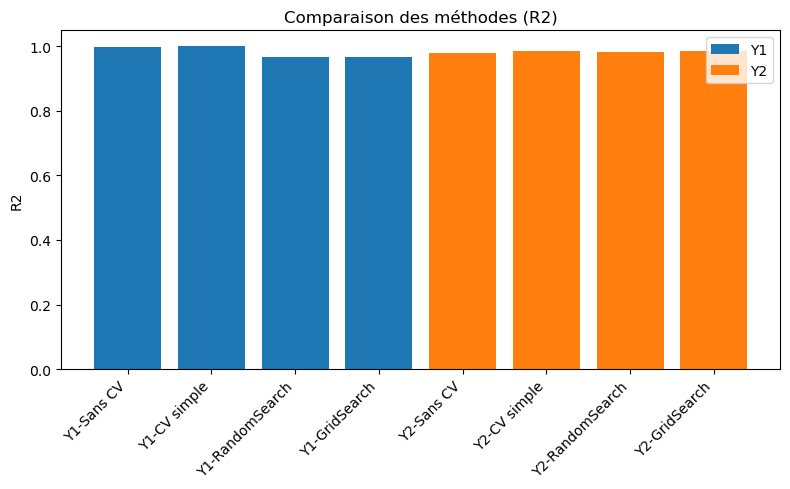

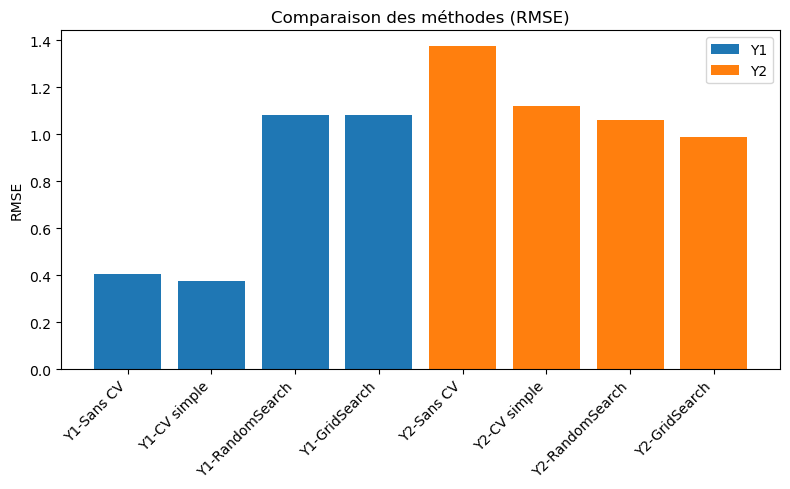

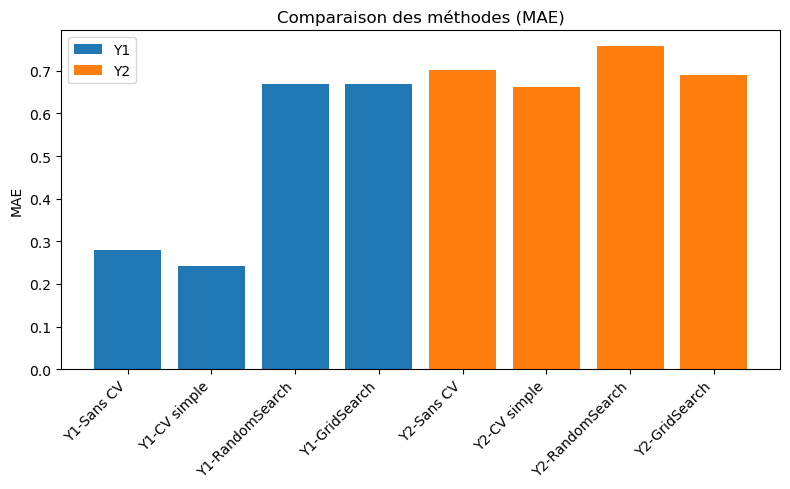

In [64]:
# --- Résultats consolidés ---
results = {
    "Y1": {
        "Sans CV":     {"Model": "XGBoost", "R2": 0.9984, "RMSE": 0.403, "MAE": 0.280},
        "CV simple":   {"Model": "XGBoost", "R2": 0.9986, "RMSE": 0.375, "MAE": 0.243},
        "RandomSearch": {"Model": "XGBoost", "R2": 0.9666, "RMSE": 1.083, "MAE": 0.669},
        "GridSearch":   {"Model": "XGBoost", "R2": 0.9667, "RMSE": 1.083, "MAE": 0.668}
    },
    "Y2": {
        "Sans CV":     {"Model": "XGBoost", "R2": 0.9796, "RMSE": 1.374, "MAE": 0.702},
        "CV simple":   {"Model": "XGBoost", "R2": 0.9858, "RMSE": 1.120, "MAE": 0.663},
        "RandomSearch": {"Model": "GradientBoosting", "R2": 0.9815, "RMSE": 1.061, "MAE": 0.757},
        "GridSearch":   {"Model": "XGBoost", "R2": 0.9839, "RMSE": 0.989, "MAE": 0.691}
    }
}

# --- Transformation en DataFrame ---
rows = []
for target, methods in results.items():
    for method, metrics in methods.items():
        rows.append([target, method, metrics["Model"], metrics["R2"], metrics["RMSE"], metrics["MAE"]])

df_results = pd.DataFrame(rows, columns=["Target", "Method", "Model", "R2", "RMSE", "MAE"])
print(df_results)

# --- Visualisation ---
metrics = ["R2", "RMSE", "MAE"]

for metric in metrics:
    plt.figure(figsize=(8,5))
    for target in df_results["Target"].unique():
        subset = df_results[df_results["Target"] == target]
        plt.bar(
            [f"{target}-{m}" for m in subset["Method"]],
            subset[metric],
            label=target
        )
    plt.title(f"Comparaison des méthodes ({metric})")
    plt.ylabel(metric)
    plt.xticks(rotation=45, ha="right")
    plt.legend()
    plt.tight_layout()
    plt.show()


  Target        Method             Model      R2   RMSE    MAE
0     Y1       Sans CV           XGBoost  0.9984  0.403  0.280
1     Y1     CV simple           XGBoost  0.9986  0.375  0.243
2     Y1  RandomSearch           XGBoost  0.9666  1.083  0.669
3     Y1    GridSearch           XGBoost  0.9667  1.083  0.668
4     Y2       Sans CV           XGBoost  0.9796  1.374  0.702
5     Y2     CV simple           XGBoost  0.9858  1.120  0.663
6     Y2  RandomSearch  GradientBoosting  0.9815  1.061  0.757
7     Y2    GridSearch           XGBoost  0.9839  0.989  0.691


C:\Users\patricia\AppData\Local\Temp\ipykernel_13220\3074386139.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(subset["Method"], rotation=45, ha="right")
C:\Users\patricia\AppData\Local\Temp\ipykernel_13220\3074386139.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(subset["Method"], rotation=45, ha="right")
C:\Users\patricia\AppData\Local\Temp\ipykernel_13220\3074386139.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(subset["Method"], rotation=45, ha="right")


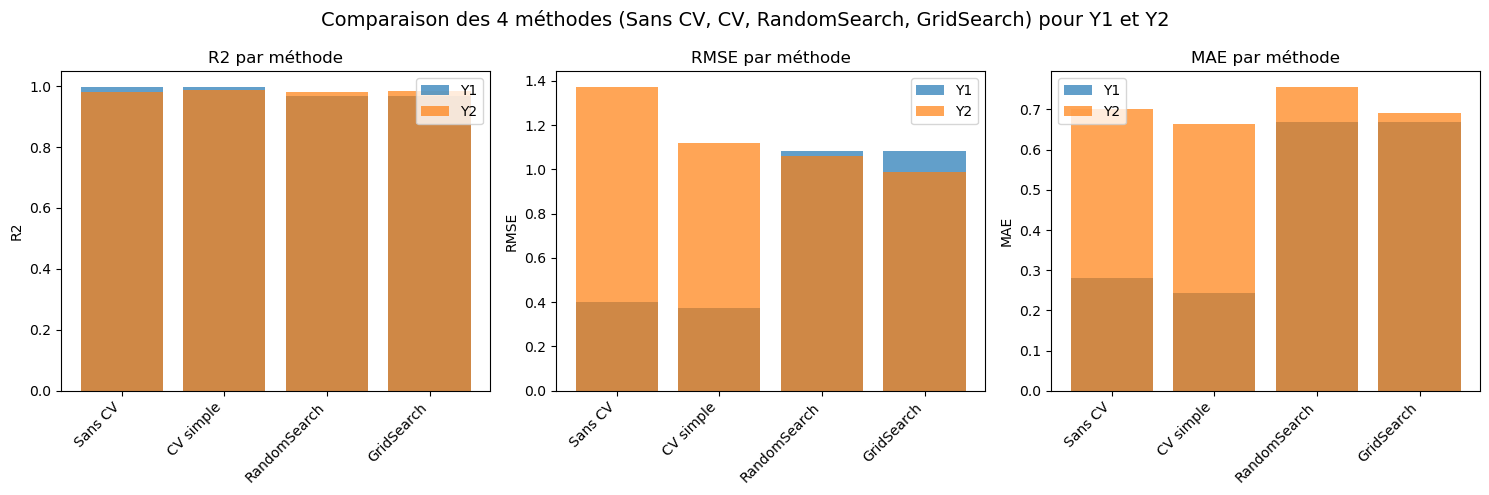

In [65]:
# --- Résultats consolidés ---
results = {
    "Y1": {
        "Sans CV":     {"Model": "XGBoost", "R2": 0.9984, "RMSE": 0.403, "MAE": 0.280},
        "CV simple":   {"Model": "XGBoost", "R2": 0.9986, "RMSE": 0.375, "MAE": 0.243},
        "RandomSearch": {"Model": "XGBoost", "R2": 0.9666, "RMSE": 1.083, "MAE": 0.669},
        "GridSearch":   {"Model": "XGBoost", "R2": 0.9667, "RMSE": 1.083, "MAE": 0.668}
    },
    "Y2": {
        "Sans CV":     {"Model": "XGBoost", "R2": 0.9796, "RMSE": 1.374, "MAE": 0.702},
        "CV simple":   {"Model": "XGBoost", "R2": 0.9858, "RMSE": 1.120, "MAE": 0.663},
        "RandomSearch": {"Model": "GradientBoosting", "R2": 0.9815, "RMSE": 1.061, "MAE": 0.757},
        "GridSearch":   {"Model": "XGBoost", "R2": 0.9839, "RMSE": 0.989, "MAE": 0.691}
    }
}

# --- Transformation en DataFrame ---
rows = []
for target, methods in results.items():
    for method, metrics in methods.items():
        rows.append([target, method, metrics["Model"], metrics["R2"], metrics["RMSE"], metrics["MAE"]])

df_results = pd.DataFrame(rows, columns=["Target", "Method", "Model", "R2", "RMSE", "MAE"])
print(df_results)

# --- Visualisation multi-métriques ---
metrics = ["R2", "RMSE", "MAE"]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, metric in enumerate(metrics):
    ax = axes[i]
    for target in df_results["Target"].unique():
        subset = df_results[df_results["Target"] == target]
        ax.bar(
            [f"{m}" for m in subset["Method"]],
            subset[metric],
            alpha=0.7,
            label=target
        )
    ax.set_title(f"{metric} par méthode")
    ax.set_ylabel(metric)
    ax.set_xticklabels(subset["Method"], rotation=45, ha="right")
    ax.legend()

plt.suptitle("Comparaison des 4 méthodes (Sans CV, CV, RandomSearch, GridSearch) pour Y1 et Y2", fontsize=14)
plt.tight_layout()
plt.show()


In [66]:
X_scaled

array([[ 2.04177671, -1.78587489, -0.56195149, ..., -0.48038446,
        -0.48038446, -0.48038446],
       [ 2.04177671, -1.78587489, -0.56195149, ..., -0.48038446,
        -0.48038446, -0.48038446],
       [ 2.04177671, -1.78587489, -0.56195149, ..., -0.48038446,
        -0.48038446, -0.48038446],
       ...,
       [-1.36381225,  1.55394308,  1.12390297, ..., -0.48038446,
        -0.48038446,  2.081666  ],
       [-1.36381225,  1.55394308,  1.12390297, ..., -0.48038446,
        -0.48038446,  2.081666  ],
       [-1.36381225,  1.55394308,  1.12390297, ..., -0.48038446,
        -0.48038446,  2.081666  ]])

In [67]:
#  10 nouveaux exemples réalistes de bâtiments
df_new_samples = pd.DataFrame([
    {
        "Relative Compactness": 0.98,
        "Surface Area": 514.5,
        "Wall Area": 294.0,
        "Roof Area": 110.25,
        "Overall Height": 3.5,
        "Orientation": 2,
        "Glazing Area": 0.0,
        "Glazing Area Distribution": 0
    },
    {
        "Relative Compactness": 0.9,
        "Surface Area": 563.5,
        "Wall Area": 318.5,
        "Roof Area": 122.5,
        "Overall Height": 7.0,
        "Orientation": 3,
        "Glazing Area": 0.1,
        "Glazing Area Distribution": 1
    },
    {
        "Relative Compactness": 0.86,
        "Surface Area": 588.0,
        "Wall Area": 343.0,
        "Roof Area": 147.0,
        "Overall Height": 3.5,
        "Orientation": 4,
        "Glazing Area": 0.25,
        "Glazing Area Distribution": 2
    },
    {
        "Relative Compactness": 0.82,
        "Surface Area": 612.5,
        "Wall Area": 416.5,
        "Roof Area": 220.5,
        "Overall Height": 7.0,
        "Orientation": 5,
        "Glazing Area": 0.4,
        "Glazing Area Distribution": 3
    },
    {
        "Relative Compactness": 0.79,
        "Surface Area": 637.0,
        "Wall Area": 245.0,
        "Roof Area": 110.25,
        "Overall Height": 3.5,
        "Orientation": 2,
        "Glazing Area": 0.1,
        "Glazing Area Distribution": 4
    },
    {
        "Relative Compactness": 0.76,
        "Surface Area": 661.5,
        "Wall Area": 269.5,
        "Roof Area": 122.5,
        "Overall Height": 7.0,
        "Orientation": 3,
        "Glazing Area": 0.25,
        "Glazing Area Distribution": 5
    },
    {
        "Relative Compactness": 0.74,
        "Surface Area": 686.0,
        "Wall Area": 367.5,
        "Roof Area": 147.0,
        "Overall Height": 3.5,
        "Orientation": 4,
        "Glazing Area": 0.4,
        "Glazing Area Distribution": 0
    },
    {
        "Relative Compactness": 0.71,
        "Surface Area": 710.5,
        "Wall Area": 294.0,
        "Roof Area": 220.5,
        "Overall Height": 7.0,
        "Orientation": 5,
        "Glazing Area": 0.0,
        "Glazing Area Distribution": 1
    },
    {
        "Relative Compactness": 0.98,
        "Surface Area": 563.5,
        "Wall Area": 318.5,
        "Roof Area": 122.5,
        "Overall Height": 3.5,
        "Orientation": 2,
        "Glazing Area": 0.25,
        "Glazing Area Distribution": 2
    },
    {
        "Relative Compactness": 0.9,
        "Surface Area": 588.0,
        "Wall Area": 343.0,
        "Roof Area": 147.0,
        "Overall Height": 7.0,
        "Orientation": 3,
        "Glazing Area": 0.4,
        "Glazing Area Distribution": 3
    }
])

print("Nouveaux échantillons à prédire :")
df_new_samples


Nouveaux échantillons à prédire :


,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution
0,0.98,514.5,294.0,110.25,3.5,2,0.00,0
1,0.90,563.5,318.5,122.50,7.0,3,0.10,1
2,0.86,588.0,343.0,147.00,3.5,4,0.25,2
3,0.82,612.5,416.5,220.50,7.0,5,0.40,3
4,0.79,637.0,245.0,110.25,3.5,2,0.10,4
5,0.76,661.5,269.5,122.50,7.0,3,0.25,5
6,0.74,686.0,367.5,147.00,3.5,4,0.40,0
7,0.71,710.5,294.0,220.50,7.0,5,0.00,1
8,0.98,563.5,318.5,122.50,3.5,2,0.25,2
9,0.90,588.0,343.0,147.00,7.0,3,0.40,3


In [68]:
"""Un DataFrame `df_new_samples` (avec les mêmes colonnes **avant encodage** : Orientation, Glazing Area Distribution, etc.).

1. **Encodage One-Hot** (mêmes colonnes que dans `df_encoded`) :"""
df_new_samples_encoded = pd.get_dummies(df_new_samples, columns=categorical_nominal, drop_first=True)

# S'assurer que toutes les colonnes sont présentes
df_new_samples_encoded = df_new_samples_encoded.reindex(columns=df_encoded.drop(columns=["Y1","Y2"]).columns, fill_value=0)
df_new_samples_encoded

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Glazing Area,Orientation_3,Orientation_4,Orientation_5,Glazing Area Distribution_1,Glazing Area Distribution_2,Glazing Area Distribution_3,Glazing Area Distribution_4,Glazing Area Distribution_5
0,0.98,514.5,294.0,110.25,3.5,0.00,False,False,False,False,False,False,False,False
1,0.90,563.5,318.5,122.50,7.0,0.10,True,False,False,True,False,False,False,False
2,0.86,588.0,343.0,147.00,3.5,0.25,False,True,False,False,True,False,False,False
3,0.82,612.5,416.5,220.50,7.0,0.40,False,False,True,False,False,True,False,False
4,0.79,637.0,245.0,110.25,3.5,0.10,False,False,False,False,False,False,True,False
5,0.76,661.5,269.5,122.50,7.0,0.25,True,False,False,False,False,False,False,True
6,0.74,686.0,367.5,147.00,3.5,0.40,False,True,False,False,False,False,False,False
7,0.71,710.5,294.0,220.50,7.0,0.00,False,False,True,True,False,False,False,False
8,0.98,563.5,318.5,122.50,3.5,0.25,False,False,False,False,True,False,False,False
9,0.90,588.0,343.0,147.00,7.0,0.40,True,False,False,False,False,True,False,False


In [69]:
"""2. **Standardisation** avec les scalers appris :"""
X_new = scaler.transform(df_new_samples_encoded)
X_new

array([[ 2.04177671, -1.78587489, -0.56195149, -1.47007664, -1.        ,
        -1.76044698, -0.57735027, -0.57735027, -0.57735027, -0.48038446,
        -0.48038446, -0.48038446, -0.48038446, -0.48038446],
       [ 1.28497917, -1.22923856,  0.        , -1.19867787,  1.        ,
        -1.00932293,  1.73205081, -0.57735027, -0.57735027,  2.081666  ,
        -0.48038446, -0.48038446, -0.48038446, -0.48038446],
       [ 0.90658039, -0.95092039,  0.56195149, -0.65588035, -1.        ,
         0.11736313, -0.57735027,  1.73205081, -0.57735027, -0.48038446,
         2.081666  , -0.48038446, -0.48038446, -0.48038446],
       [ 0.52818162, -0.67260223,  2.24780595,  0.97251224,  1.        ,
         1.2440492 , -0.57735027, -0.57735027,  1.73205081, -0.48038446,
        -0.48038446,  2.081666  , -0.48038446, -0.48038446],
       [ 0.24438254, -0.39428407, -1.68585446, -1.47007664, -1.        ,
        -1.00932293, -0.57735027, -0.57735027, -0.57735027, -0.48038446,
        -0.48038446, -0.48

In [70]:
df_new_samples["Pred_Y1"] = best_model_y1.predict(X_new)
df_new_samples["Pred_Y2"] = best_model_y2.predict(X_new)
#print(df_new_samples)

   Relative Compactness  Surface Area  Wall Area  Roof Area  Overall Height  \
0                  0.98         514.5      294.0     110.25             3.5   
1                  0.90         563.5      318.5     122.50             7.0   
2                  0.86         588.0      343.0     147.00             3.5   
3                  0.82         612.5      416.5     220.50             7.0   
4                  0.79         637.0      245.0     110.25             3.5   
5                  0.76         661.5      269.5     122.50             7.0   
6                  0.74         686.0      367.5     147.00             3.5   
7                  0.71         710.5      294.0     220.50             7.0   
8                  0.98         563.5      318.5     122.50             3.5   
9                  0.90         588.0      343.0     147.00             7.0   

   Orientation  Glazing Area  Glazing Area Distribution    Pred_Y1    Pred_Y2  
0            2          0.00                      

In [71]:
df_new_samples

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Pred_Y1,Pred_Y2
0,0.98,514.5,294.0,110.25,3.5,2,0.00,0,15.593767,21.516148
1,0.90,563.5,318.5,122.50,7.0,3,0.10,1,29.839613,29.864666
2,0.86,588.0,343.0,147.00,3.5,4,0.25,2,32.534718,31.684002
3,0.82,612.5,416.5,220.50,7.0,5,0.40,3,28.864298,29.203688
4,0.79,637.0,245.0,110.25,3.5,2,0.10,4,36.542889,35.430393
5,0.76,661.5,269.5,122.50,7.0,3,0.25,5,36.450378,36.978962
6,0.74,686.0,367.5,147.00,3.5,4,0.40,0,14.447092,16.865112
7,0.71,710.5,294.0,220.50,7.0,5,0.00,1,6.325234,11.635638
8,0.98,563.5,318.5,122.50,3.5,2,0.25,2,31.806948,32.251766
9,0.90,588.0,343.0,147.00,7.0,3,0.40,3,34.947063,37.080311
